<a href="https://www.kaggle.com/code/jaksanders/electric-load-forecasting-with-deep-learning?scriptVersionId=147243267" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import IPython
import IPython.display
import glob
import time
import pickle
import warnings
warnings.filterwarnings("ignore")
randomState = 42 # tip of the cap to Douglas Adams

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-o

# Load Data

## Load half-hourly electric usage data
...for ~5k smart meters in London
[SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)

In [2]:
# load half-hourly electric usage data
# takes about four minutes, need to find somerthing faster like Dask?
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
# Get CSV files list from a folder
path = '/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
start_time = time.time()
df_list = (pd.read_csv(file, parse_dates=["tstp"]) for file in csv_files)
print('%s seconds' % (time.time() - start_time))

# Concatenate all DataFrames
start_time = time.time()
d = pd.concat(df_list, ignore_index=True)
print('%s seconds' % (time.time() - start_time))

0.00012826919555664062 seconds
276.69714307785034 seconds


In [3]:
d.describe()

LCLid                 tstp energy(kWh/hh)
count   167817021            167817021      167817021
unique       5566                40405           9611
top     MAC000147  2012-11-19 00:30:00             0 
freq        39725                 5531        2001094
first         NaN  2011-11-23 09:00:00            NaN
last          NaN  2014-02-28 00:00:00            NaN

## Load hourly weather data

In [4]:
# load hourly weather data
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
weatherData = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=["time"])

In [5]:
weatherData.describe()

visibility   windBearing   temperature      dewPoint      pressure  \
count  21165.000000  21165.000000  21165.000000  21165.000000  21152.000000   
mean      11.166485    195.685897     10.471486      6.530501   1014.125153   
std        3.099337     90.629453      5.781904      5.041965     11.388337   
min        0.180000      0.000000     -5.640000     -9.980000    975.740000   
25%       10.120000    121.000000      6.470000      2.820000   1007.430000   
50%       12.260000    217.000000      9.930000      6.570000   1014.780000   
75%       13.080000    256.000000     14.310000     10.330000   1022.050000   
max       16.090000    359.000000     32.400000     19.880000   1043.320000   

       apparentTemperature     windSpeed      humidity  
count         21165.000000  21165.000000  21165.000000  
mean              9.230338      3.905215      0.781829  
std               6.940919      2.026854      0.140369  
min              -8.880000      0.040000      0.230000  
25%               3.900000      2.420000      0.700000  
50%               9.360000      3.680000      0.810000  
75%              14.320000      5.070000      0.890000  
max              32.420000     14.800000      1.000000

In [6]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visibility           21165 non-null  float64       
 1   windBearing          21165 non-null  int64         
 2   temperature          21165 non-null  float64       
 3   time                 21165 non-null  datetime64[ns]
 4   dewPoint             21165 non-null  float64       
 5   pressure             21152 non-null  float64       
 6   apparentTemperature  21165 non-null  float64       
 7   windSpeed            21165 non-null  float64       
 8   precipType           21165 non-null  object        
 9   icon                 21165 non-null  object        
 10  humidity             21165 non-null  float64       
 11  summary              21165 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 1.9+ MB


# Data pre-processing and cleaning

## Weather data: convert text attributes to string datatype

In [7]:
weatherData = weatherData.astype({'precipType':'string', 'icon':'string', 'summary':'string'})

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(weatherData, tsmode=True, sortby="time")
profile.to_file('weatherData profile_report.html')
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Identify and remove weather records not exactly on the hour

In [9]:
# inspect and remove records not exactly on the hour
offRecs = weatherData.query("time.dt.minute != 0 or time.dt.second != 0")
print('Records not exactly on the half-hour:\n ', offRecs)

Records not exactly on the half-hour:
  Empty DataFrame
Columns: [visibility, windBearing, temperature, time, dewPoint, pressure, apparentTemperature, windSpeed, precipType, icon, humidity, summary]
Index: []


In [10]:
# select weather data features of interest
weatherUpsample = weatherData[['time','temperature', 'dewPoint']].copy()
# weatherUpsample = weatherData[['time','temperature', 'dewPoint', 'pressure', 'humidity']].copy()
# pressure and humidity removed due to permutation feature importance
weatherUpsample = weatherUpsample.sort_values(by=['time'])
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21165 entries, 312 to 20276
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         21165 non-null  datetime64[ns]
 1   temperature  21165 non-null  float64       
 2   dewPoint     21165 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 661.4 KB
None
        temperature      dewPoint
count  21165.000000  21165.000000
mean      10.471486      6.530501
std        5.781904      5.041965
min       -5.640000     -9.980000
25%        6.470000      2.820000
50%        9.930000      6.570000
75%       14.310000     10.330000
max       32.400000     19.880000
                     time  temperature  dewPoint
312   2011-11-01 00:00:00        13.49     11.48
313   2011-11-01 01:00:00        12.73     11.58
314   2011-11-01 02:00:00        13.65     12.14
315   2011-11-01 03:00:00        14.13     12.24
316   2011-11-01 04:00:00   

## Upsample weather data to match half-houly sampling rate of load data

In [11]:
# get the index set up to support the resamle operation
weatherUpsample.set_index('time', inplace=True)
weatherUpsample.index.rename('time', inplace=True)

start_time = time.time()
weatherUpsample = weatherUpsample.resample('30Min').mean()

# upsample 
weatherUpsample['temperature'] = weatherUpsample['temperature'].interpolate()
weatherUpsample['dewPoint'] = weatherUpsample['dewPoint'].interpolate()
# weatherUpsample['pressure'] = weatherUpsample['pressure'].interpolate()
# weatherUpsample['humidity'] = weatherUpsample['humidity'].interpolate()

print('%s seconds' % (time.time() - start_time))

weatherUpsample = weatherUpsample.reset_index(names='DateTime')
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

0.02846693992614746 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42333 entries, 0 to 42332
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     42333 non-null  datetime64[ns]
 1   temperature  42333 non-null  float64       
 2   dewPoint     42333 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 992.3 KB
None
        temperature      dewPoint
count  42333.000000  42333.000000
mean      10.471414      6.530646
std        5.775688      5.037766
min       -5.640000     -9.980000
25%        6.475000      2.830000
50%        9.935000      6.575000
75%       14.320000     10.325000
max       32.400000     19.880000
                 DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4 

In [12]:
# save weather data so we don't have to do pre-processing again
weatherUpsample.to_csv('/kaggle/working/WeatherDataFinal.csv',index=False)

In [13]:
# load pre-processed weather data
weatherUpsample = pd.read_csv('/kaggle/working/WeatherDataFinal.csv', parse_dates=["DateTime"])
weatherUpsample

DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4     2011-11-01 02:00:00       13.650    12.140
...                   ...          ...       ...
42328 2014-03-31 20:00:00       13.620     7.910
42329 2014-03-31 20:30:00       13.325     7.935
42330 2014-03-31 21:00:00       13.030     7.960
42331 2014-03-31 21:30:00       12.770     7.965
42332 2014-03-31 22:00:00       12.510     7.970

[42333 rows x 3 columns]

In [14]:
print(weatherUpsample)


                 DateTime  temperature  dewPoint
0     2011-11-01 00:00:00       13.490    11.480
1     2011-11-01 00:30:00       13.110    11.530
2     2011-11-01 01:00:00       12.730    11.580
3     2011-11-01 01:30:00       13.190    11.860
4     2011-11-01 02:00:00       13.650    12.140
...                   ...          ...       ...
42328 2014-03-31 20:00:00       13.620     7.910
42329 2014-03-31 20:30:00       13.325     7.935
42330 2014-03-31 21:00:00       13.030     7.960
42331 2014-03-31 21:30:00       12.770     7.965
42332 2014-03-31 22:00:00       12.510     7.970

[42333 rows x 3 columns]


In [15]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   energy(kWh/hh)  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 3.8+ GB


In [16]:
# utility function to nicely format variable names and memory they are consuming
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Convert smart meter usage datatype to float

In [17]:
# ~1 minute
start_time = time.time()
d.iloc[:, 2] = pd.to_numeric(d.iloc[:, 2], errors='coerce')
print('%s seconds' % (time.time() - start_time))

# rename usage column for easier reference
d.rename(columns={d.columns[2]: 'KWHperHH'}, inplace=True)
d.info()

53.46871304512024 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


In [18]:
# set timestamp as the index
start_time = time.time()
d.set_index('tstp')
print('%s seconds' % (time.time() - start_time))

4.74870228767395 seconds


## Identify and handle duplicates in the smart meter data

In [19]:
# about 1.5 minutes
start_time = time.time()
dupes = d[d.duplicated()]
print('dupes', dupes)
print('dupes.index', dupes.index)
d.drop(index=dupes.index, inplace=True)
print('%s seconds' % (time.time() - start_time))

dupes Empty DataFrame
Columns: [LCLid, tstp, KWHperHH]
Index: []
dupes.index Int64Index([], dtype='int64')
85.62374758720398 seconds


In [20]:
# set index for the usage data to the timestamp column.  Is this necessary?  Can't remember why
start_time = time.time()
d.set_index('tstp')
d.info()
print('%s seconds' % (time.time() - start_time))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB
4.28844690322876 seconds


In [21]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 12.8 GiB
                   weatherData:  5.5 MiB
                             _: 992.3 KiB
               weatherUpsample: 992.3 KiB
                           _13: 992.3 KiB
                           ___:  1.3 KiB
                            _3:  1.3 KiB
                 ProfileReport:  1.2 KiB
                     csv_files:  1.1 KiB
                            __: 1011.0 B


# Visualize smart meter dataset to analyze for quality, completenes and other insights

## grab a random sample of 2% of meters for visualization and analysis

In [22]:
rng = np.random.default_rng(randomState)
# random_state = np.random.RandomState(randomState)
sampleMeters = rng.choice(d.LCLid.unique(), size=int(len(d.LCLid.unique())*0.02), replace=False)
print('sampleMeters:\n', sampleMeters)
sample = d[d['LCLid'].isin(sampleMeters)]
print('sample:\n', sample)
print(sample.describe())
# print(sample.info())

sampleMeters:
 ['MAC003787' 'MAC004997' 'MAC000079' 'MAC001558' 'MAC001656' 'MAC001938'
 'MAC003313' 'MAC001152' 'MAC002826' 'MAC000272' 'MAC000133' 'MAC001726'
 'MAC004462' 'MAC003604' 'MAC001933' 'MAC003085' 'MAC004775' 'MAC005467'
 'MAC002659' 'MAC005353' 'MAC003411' 'MAC005264' 'MAC000875' 'MAC001330'
 'MAC002750' 'MAC003007' 'MAC003705' 'MAC003049' 'MAC003468' 'MAC004190'
 'MAC002703' 'MAC000477' 'MAC000020' 'MAC003603' 'MAC001982' 'MAC003471'
 'MAC000878' 'MAC004084' 'MAC001267' 'MAC004947' 'MAC001665' 'MAC005543'
 'MAC001762' 'MAC003512' 'MAC000071' 'MAC000089' 'MAC005269' 'MAC004873'
 'MAC000118' 'MAC001493' 'MAC003876' 'MAC005095' 'MAC002583' 'MAC005132'
 'MAC004659' 'MAC004419' 'MAC002866' 'MAC002854' 'MAC001995' 'MAC004157'
 'MAC002860' 'MAC004271' 'MAC000407' 'MAC002805' 'MAC004927' 'MAC001184'
 'MAC001159' 'MAC002448' 'MAC003486' 'MAC001054' 'MAC003291' 'MAC005448'
 'MAC002654' 'MAC003222' 'MAC004803' 'MAC004460' 'MAC003087' 'MAC000214'
 'MAC003040' 'MAC000183' 'MAC000653'

In [23]:
sample.to_csv('/kaggle/working/sampleMeters.csv',index=False)

In [24]:
sample = pd.read_csv('/kaggle/working/sampleMeters.csv', parse_dates=["tstp"])
sample

LCLid                tstp  KWHperHH
0        MAC001330 2012-05-17 11:00:00     0.157
1        MAC001330 2012-05-17 11:30:00     0.192
2        MAC001330 2012-05-17 12:00:00     0.675
3        MAC001330 2012-05-17 12:30:00     0.418
4        MAC001330 2012-05-17 13:00:00     1.446
...            ...                 ...       ...
3410959  MAC005448 2014-02-27 22:00:00     0.144
3410960  MAC005448 2014-02-27 22:30:00     0.086
3410961  MAC005448 2014-02-27 23:00:00     0.053
3410962  MAC005448 2014-02-27 23:30:00     0.058
3410963  MAC005448 2014-02-28 00:00:00     0.048

[3410964 rows x 3 columns]

## Heatmap to visualize meter read coverage and completeness

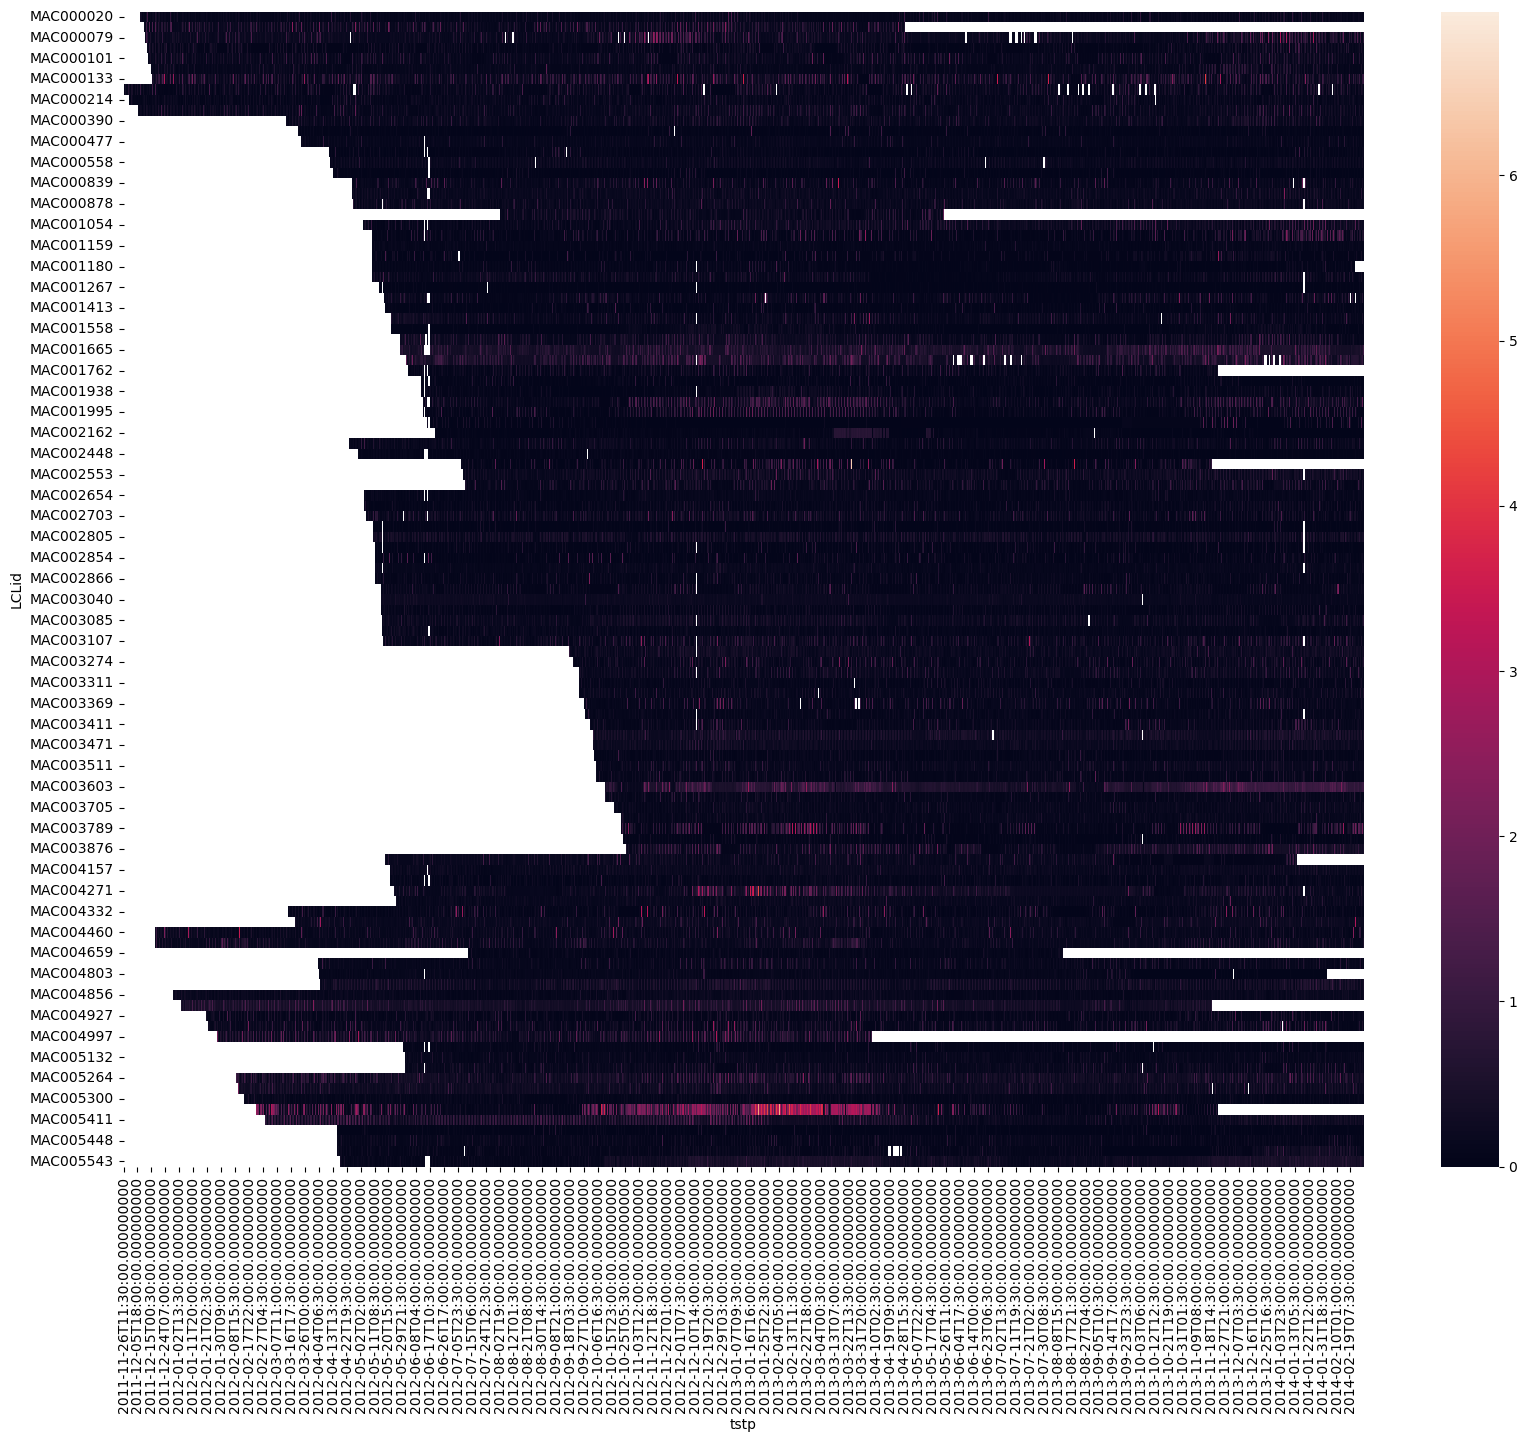

In [25]:
# visualize meter read coverage and completeness
# using a random sample of 2% of meters
plt.subplots(figsize=(20,15))
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='KWHperHH')
sns.heatmap(pivot_table)
plt.savefig('meter data heatmap.png', format='png')

Observations from Heatmap...
* several houses start producing load part-way through the period
    - eg MAC004221, MAC004248
    
    
* several houses stop producing part-way through the period
    - eg MAC004226, MAC004257
    

* most houses have at least one "gap" in their data (visible as white lines)


* several houses stand out as having significantly higher average load than others
    - eg MAC004225, MAC004249

## Identify and remove smart meter readings not exactly on the half-hour

In [26]:
# identify and remove records not exactly on the half-hour
start_time = time.time()

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('Records not exactly on the half-hour:\n ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
d.drop(offRecs.index, inplace=True)

print('%s seconds' % (time.time() - start_time))

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:
                 LCLid                tstp  KWHperHH
18051      MAC000047 2012-12-18 15:13:44       NaN
52485      MAC000362 2012-12-18 15:15:14       NaN
86881      MAC000385 2012-12-18 15:15:16       NaN
120772     MAC000486 2012-12-18 15:15:42       NaN
138889     MAC000507 2012-12-18 15:15:45       NaN
...              ...                 ...       ...
167658239  MAC005035 2012-12-18 15:14:33       NaN
167694593  MAC005048 2012-12-18 15:14:35       NaN
167730712  MAC005229 2012-12-18 15:14:41       NaN
167763454  MAC005448 2012-12-18 15:16:23       NaN
167796074  MAC005508 2012-12-18 15:16:29       NaN

[5560 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5560 entries, 18051 to 167796074
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   LCLid     5560 non-null   object        
 1   tstp      5560 non-null   datetime64[ns]
 2   KWHperHH  0 non-nul

In [27]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167811461 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.0+ GB


In [28]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 14.1 GiB
                             _: 266.7 MiB
                        sample: 266.7 MiB
                           _24: 266.7 MiB
                   pivot_table: 33.5 MiB
                   weatherData:  5.5 MiB
                            __: 992.3 KiB
               weatherUpsample: 992.3 KiB
                           _13: 992.3 KiB
                            _3:  1.3 KiB


## Fill gaps in the smart meter data

Our heatmap above shows lots of gaps (small white vertical lines), and we'll fill those gaps using interpolation

### First step of filling these gaps is to create NaN records where records are missing

Then we can fill these gas with interpolation

In [29]:
# First step of interpolation is to create NaN records where records are missing
# about 2 minutes
d.sort_values(by=['tstp'], inplace=True)
d.set_index('tstp', inplace=True)
d.index.rename('tstp', inplace=True)

start_time = time.time()
# resample to create NaN records where records are missing
d = d.groupby('LCLid')\
                .resample('30Min')\
                .mean()

# fill the gaps with interpolation
d['KWHperHH'] = d['KWHperHH'].interpolate()
d.reset_index(inplace=True)

print('%s seconds' % (time.time() - start_time))

128.85556364059448 seconds


## Check the meter data heatmap to see if gaps have been filled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168268119 entries, 0 to 168268118
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


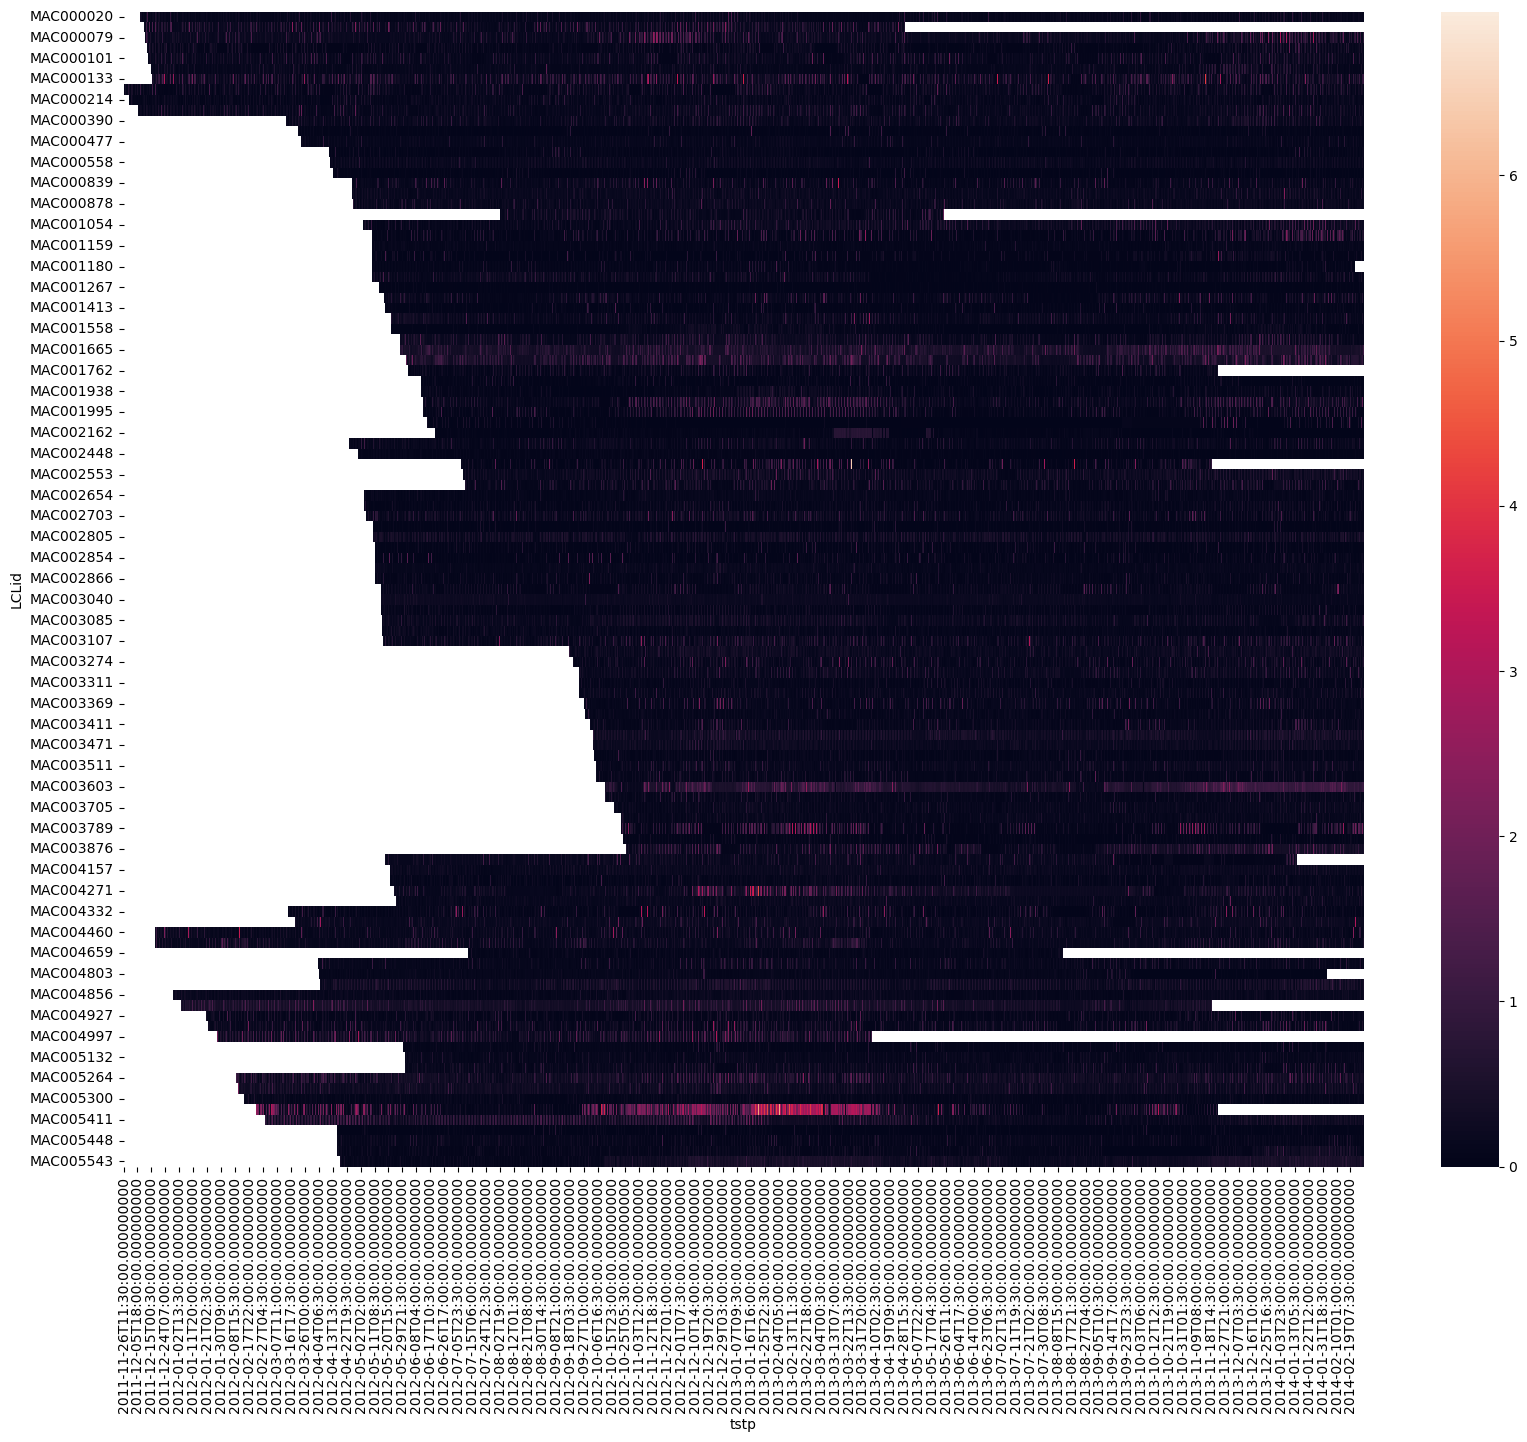

In [30]:
# visualize after interpolating missing values
d.info()
sample = d[d['LCLid'].isin(sampleMeters)]
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='KWHperHH')
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)
plt.savefig('meter data heatmap gaps filled.png', format='png')

## Visualize zeros in the dataset using heatmap

I'm always curious to understand zeros in a dataset, and whether they are legitimate zero values, or indicate a data quality problem.

7.772168397903442 seconds


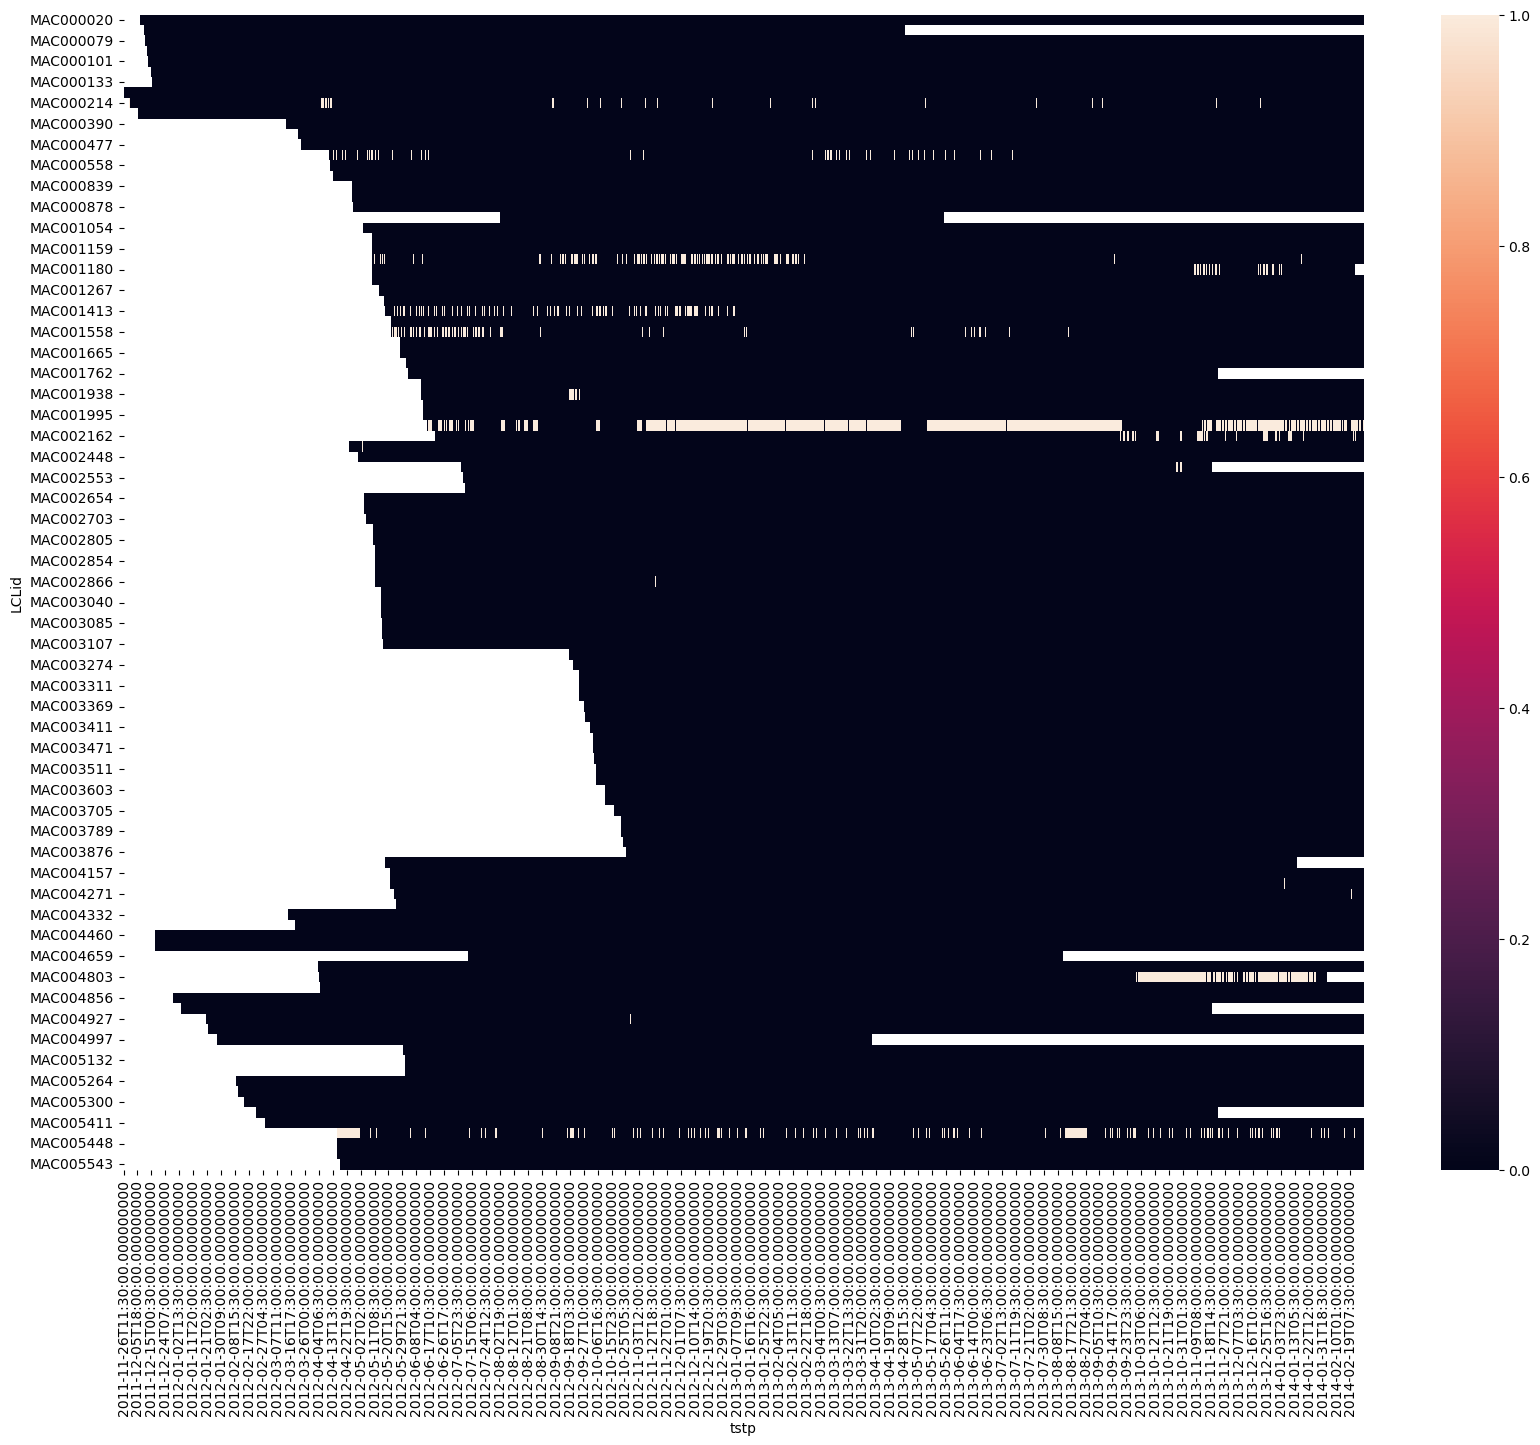

In [31]:
# visualize zeros in the dataset
start_time = time.time()
sample = d[d['LCLid'].isin(sampleMeters)]
sample['ZeroKWHperHH'] = sample['KWHperHH'] == 0
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='ZeroKWHperHH')
print('%s seconds' % (time.time() - start_time))
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)
plt.savefig('meter data heatmap zeros.png', format='png')

In [32]:
# take a snapshot of data
# takes about 11 minutes
start_time = time.time()
d.to_csv('/kaggle/working/MeterDataFinal.csv',index=False)
print('%s seconds' % (time.time() - start_time))

702.1804332733154 seconds


### Obervation

There are a handful of households that account all the zero value meter reads: MAC004233, MAC004226, MAC004267

In [33]:
sampleMetersWithZeroReads = sample[sample['KWHperHH'] == 0].groupby('LCLid').agg('count')
sampleMetersWithZeroReads

tstp  KWHperHH  ZeroKWHperHH
LCLid                                   
MAC000133      5         5             5
MAC000214    684       684           684
MAC000390      4         4             4
MAC000549   1181      1181          1181
MAC000653      1         1             1
MAC001159      3         3             3
MAC001170   3825      3825          3825
MAC001180    704       704           704
MAC001413   2502      2502          2502
MAC001558   1989      1989          1989
MAC001933      5         5             5
MAC001938    303       303           303
MAC001982      1         1             1
MAC002050  19820     19820         19820
MAC002162   2812      2812          2812
MAC002320     19        19            19
MAC002510    135       135           135
MAC002805      3         3             3
MAC002866     23        23            23
MAC003040      3         3             3
MAC003085     11        11            11
MAC003274      1         1             1
MAC003486      4         4             4
MAC003789      2         2             2
MAC003837      4         4             4
MAC004157      2         2             2
MAC004190     88        88            88
MAC004271     43        43            43
MAC004460      1         1             1
MAC004803   4939      4939          4939
MAC004927     14        14            14
MAC005445   5315      5315          5315
MAC005543      4         4             4

              LCLid                tstp  KWHperHH  ZeroKWHperHH
64435506  MAC002050 2012-06-15 00:30:00       0.0          True
64435507  MAC002050 2012-06-15 01:00:00       0.0          True
64435508  MAC002050 2012-06-15 01:30:00       0.0          True
64435509  MAC002050 2012-06-15 02:00:00       0.0          True
64435510  MAC002050 2012-06-15 02:30:00       0.0          True
...             ...                 ...       ...           ...
64465405  MAC002050 2014-02-27 22:00:00       0.0          True
64465406  MAC002050 2014-02-27 22:30:00       0.0          True
64465407  MAC002050 2014-02-27 23:00:00       0.0          True
64465408  MAC002050 2014-02-27 23:30:00       0.0          True
64465409  MAC002050 2014-02-28 00:00:00       0.0          True

[29904 rows x 4 columns]


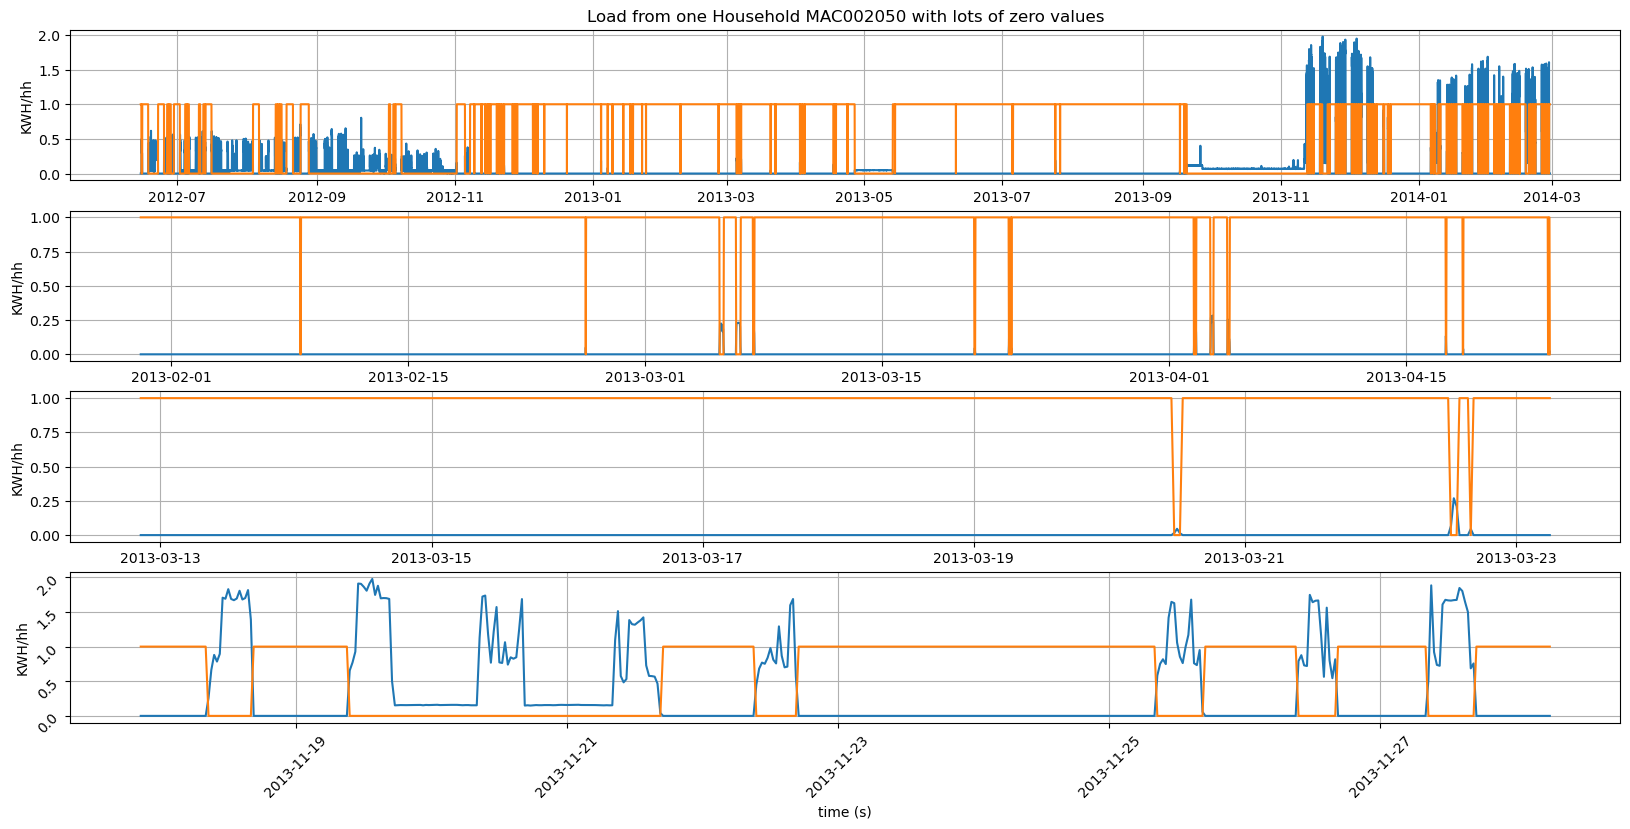

In [34]:
# investigate the meters with zero reads
MAC002050 = sample.query("LCLid == 'MAC002050'")
print(MAC002050)
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC002050.tstp, MAC002050.KWHperHH)
ax[0].plot(MAC002050.tstp, MAC002050.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC002050 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC002050.tstp[11000:15000], MAC002050.KWHperHH[11000:15000])
ax[1].plot(MAC002050.tstp[11000:15000], MAC002050.ZeroKWHperHH[11000:15000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC002050.tstp[13000:13500], MAC002050.KWHperHH[13000:13500])
ax[2].plot(MAC002050.tstp[13000:13500], MAC002050.ZeroKWHperHH[13000:13500])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC002050.tstp[25000:25500], MAC002050.KWHperHH[25000:25500])
ax[3].plot(MAC002050.tstp[25000:25500], MAC002050.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC002050.png")
plt.show()

### Observation:
The zeros for MAC004233 seem legit - leaving them in

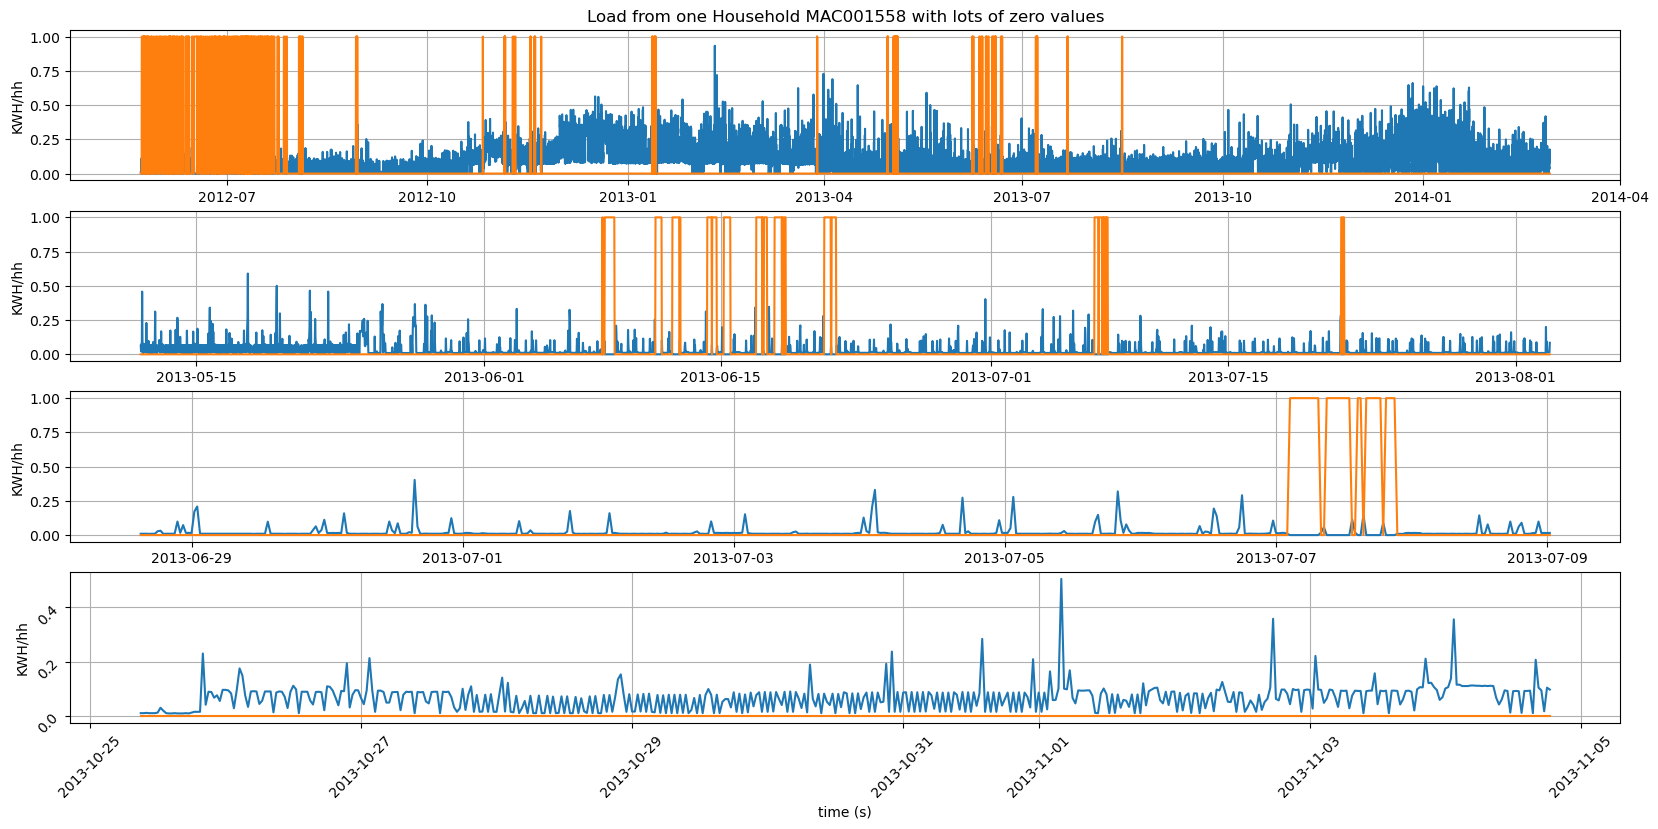

In [35]:
# investigate the meters with zero reads
MAC001558 = sample.query("LCLid == 'MAC001558'")
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC001558.tstp, MAC001558.KWHperHH)
ax[0].plot(MAC001558.tstp, MAC001558.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC001558 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC001558.tstp[17000:21000], MAC001558.KWHperHH[17000:21000])
ax[1].plot(MAC001558.tstp[17000:21000], MAC001558.ZeroKWHperHH[17000:21000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC001558.tstp[19300:19800], MAC001558.KWHperHH[19300:19800])
ax[2].plot(MAC001558.tstp[19300:19800], MAC001558.ZeroKWHperHH[19300:19800])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC001558.tstp[25000:25500], MAC001558.KWHperHH[25000:25500])
ax[3].plot(MAC001558.tstp[25000:25500], MAC001558.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC001558.png")
plt.show()

### Observation

The zeros for MAC004233 seem legit - leaving them in


In [36]:
# visualize and handle outliers

# minumum and maximum timestamp for each house
print(d.groupby('LCLid').max().sort_values('tstp'))
print(d.groupby('LCLid').min().sort_values('tstp'))
print(d.groupby('LCLid').count().sort_values('tstp'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))


                         tstp  KWHperHH
LCLid                                  
MAC001300 2012-05-22 23:30:00     1.697
MAC001278 2012-05-24 23:30:00     1.168
MAC005565 2012-06-21 07:00:00     1.022
MAC001957 2012-06-26 00:00:00     0.940
MAC002110 2012-06-26 10:00:00     0.919
...                       ...       ...
MAC001976 2014-02-28 00:00:00     2.751
MAC001975 2014-02-28 00:00:00     2.096
MAC001974 2014-02-28 00:00:00     2.623
MAC001993 2014-02-28 00:00:00     1.347
MAC005567 2014-02-28 00:00:00     1.528

[5561 rows x 2 columns]
                         tstp  KWHperHH
LCLid                                  
MAC000145 2011-11-23 09:00:00     0.024
MAC000146 2011-11-23 09:00:00     0.031
MAC000147 2011-11-23 10:00:00     0.008
MAC000148 2011-11-23 10:00:00     0.000
MAC000149 2011-11-23 10:00:00     0.000
...                       ...       ...
MAC003155 2013-07-04 00:30:00     0.047
MAC005510 2013-09-21 00:30:00     0.000
MAC001477 2013-10-23 00:30:00     0.018
MAC001653 2013-

In [37]:
# which house has the highest peak load?

# which house has the highest total aggregate load?

# how variable / predictable is the timing of the peak load

# how accurate is the next 24 hours forecast profile overall?

# how accurate is the peak load forecast in next 24 hours?

# normalize and standardize


In [38]:
# extract one smartmeter for plotting
sample = d.query("LCLid == 'MAC004233'")
sample

LCLid                tstp  KWHperHH
124559531  MAC004233 2012-05-23 12:00:00     0.009
124559532  MAC004233 2012-05-23 12:30:00     0.016
124559533  MAC004233 2012-05-23 13:00:00     0.691
124559534  MAC004233 2012-05-23 13:30:00     0.154
124559535  MAC004233 2012-05-23 14:00:00     0.024
...              ...                 ...       ...
124590511  MAC004233 2014-02-27 22:00:00     0.116
124590512  MAC004233 2014-02-27 22:30:00     0.123
124590513  MAC004233 2014-02-27 23:00:00     0.036
124590514  MAC004233 2014-02-27 23:30:00     0.037
124590515  MAC004233 2014-02-28 00:00:00     0.020

[30985 rows x 3 columns]

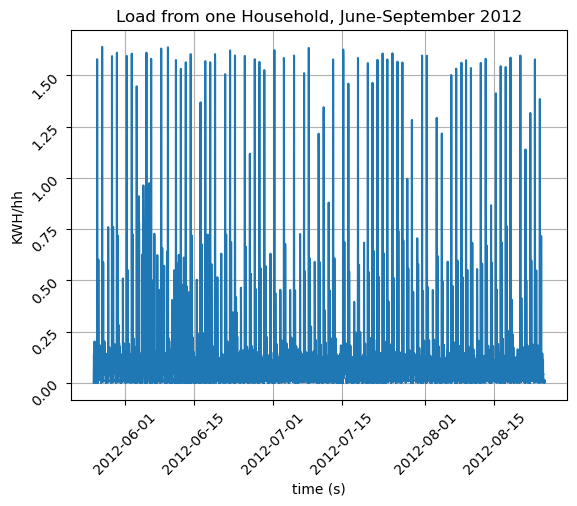

In [39]:
# Visualize load profile for one household meter
fig, ax = plt.subplots()
ax.plot(sample.iloc[100:4500,1], sample.iloc[100:4500,2])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Load from one Household, June-September 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Load from one Household, June-September 2012.png")
plt.show()

In [40]:
# set index for the sample
sample.set_index('tstp')

LCLid  KWHperHH
tstp                                    
2012-05-23 12:00:00  MAC004233     0.009
2012-05-23 12:30:00  MAC004233     0.016
2012-05-23 13:00:00  MAC004233     0.691
2012-05-23 13:30:00  MAC004233     0.154
2012-05-23 14:00:00  MAC004233     0.024
...                        ...       ...
2014-02-27 22:00:00  MAC004233     0.116
2014-02-27 22:30:00  MAC004233     0.123
2014-02-27 23:00:00  MAC004233     0.036
2014-02-27 23:30:00  MAC004233     0.037
2014-02-28 00:00:00  MAC004233     0.020

[30985 rows x 2 columns]

# EDA: Visualize daily average load for each meter and all meters...

51.71370768547058 seconds
60.01083493232727 seconds


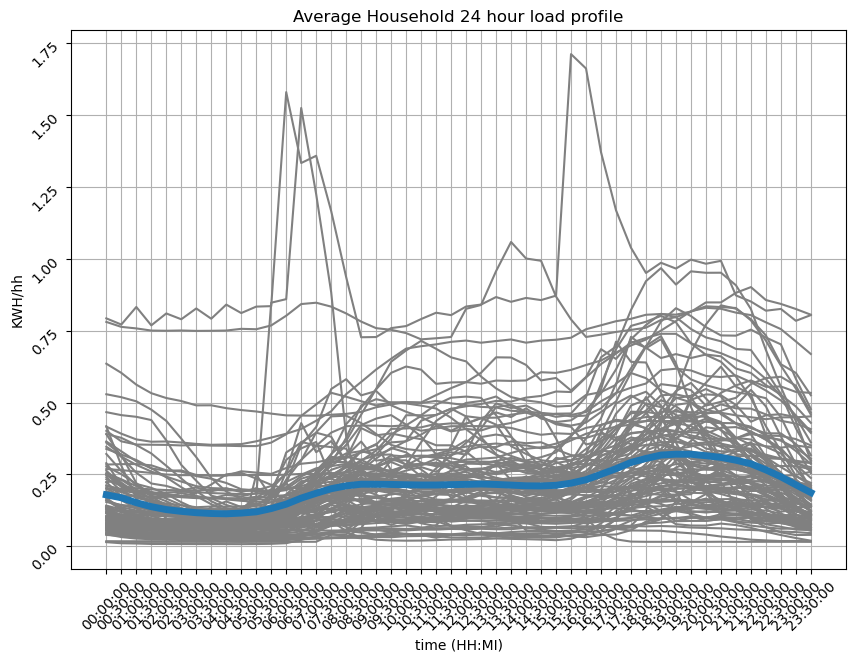

In [41]:
# calculate average daily load profile for all meters...
# abut 1.5 minutes

start_time = time.time()
avgLoadProfile = pd.DataFrame(d.groupby([d['tstp'].dt.hour, d['tstp'].dt.minute]).KWHperHH.mean())
avgLoadProfile = avgLoadProfile.reset_index(names=['hour', 'minute'])
avgLoadProfile['labels'] = pd.to_datetime(avgLoadProfile['hour'].astype(str) + ':' + avgLoadProfile['minute'].astype(str), format='%H:%M').dt.time
print('%s seconds' % (time.time() - start_time))

# print(avgLoadProfile.info())
# print(avgLoadProfile)

fig, ax = plt.subplots(figsize=(10,7))

ax.set_xticks(avgLoadProfile.index, avgLoadProfile.labels)

ax.set(xlabel='time (HH:MI)', ylabel='KWH/hh',
       title='Average Household 24 hour load profile')

# calculate average daily load for each meter...
start_time = time.time()
avgLoadProfileEachMeter = pd.DataFrame(d.groupby(['LCLid', d['tstp'].dt.hour, d['tstp'].dt.minute]).agg({'KWHperHH': 'mean'}))
avgLoadProfileEachMeter = avgLoadProfileEachMeter.reset_index(names=['LCLid', 'hour', 'minute'])
print('%s seconds' % (time.time() - start_time))
# print(avgLoadProfileEachMeter.info())
# print(avgLoadProfileEachMeter)

# plot every sample meter
for meter in sampleMeters:
    # print(meter)
    ax.plot(avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].index % 48, 
            avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].KWHperHH,
           color='grey')

# plot the average
ax.plot(avgLoadProfile.index, avgLoadProfile.KWHperHH, linewidth=5)

plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Avg 24hr Load Profile every meter.png")
plt.show()

## Create aggregate features: aggregate load (our target) and count of meters

In [42]:
# Calculate the sum of all loads and count of smart meters for each timestamp
start_time = time.time()
aggLoad = pd.DataFrame(d.groupby('tstp')['KWHperHH'].agg({'sum', 'count'}))
aggLoad.reset_index(inplace=True)
aggLoad.columns = ['tstp', 'AggregateLoad', 'numMeters']
print('%s seconds' % (time.time() - start_time))

print(aggLoad)
print(aggLoad.describe())
print(aggLoad.info())

5.381448745727539 seconds
                     tstp  AggregateLoad  numMeters
0     2011-11-23 09:00:00       0.569000          2
1     2011-11-23 09:30:00       0.561000          2
2     2011-11-23 10:00:00       0.920000          6
3     2011-11-23 10:30:00       0.588000          6
4     2011-11-23 11:00:00       0.772000          7
...                   ...            ...        ...
39722 2014-02-27 22:00:00    1494.829500       4987
39723 2014-02-27 22:30:00    1422.109001       4987
39724 2014-02-27 23:00:00    1258.090000       4987
39725 2014-02-27 23:30:00    1073.622001       4987
39726 2014-02-28 00:00:00    1042.266000       4987

[39727 rows x 3 columns]
       AggregateLoad     numMeters
count   39727.000000  39727.000000
mean      896.369164   4235.611020
std       518.309150   1791.296166
min         0.561000      2.000000
25%       533.251967   4089.000000
50%       876.796386   5137.000000
75%      1222.138521   5371.000000
max      2608.409794   5533.000000
<class 'p

In [43]:
aggLoad.sort_values(by=['tstp'], inplace=True)
aggLoad.set_index('tstp', inplace=True)
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AggregateLoad  39727 non-null  float64
 1   numMeters      39727 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 931.1 KB


In [44]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


In [45]:
# inspect and fix records with zero load
# start with the aggregated records with zero load
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros

Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []

Observation: Some of the timestamps are not exactly on the half-hour
Question: How many of the timestamps are not exactly on the half-hour?

In [46]:
# inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  0 non-null      float64       
 1   numMeters      0 non-null      int64         
 2   DateTime       0 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 0.0 bytes
None
Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []


In [47]:
# check the regularity of the observations (time between observations)
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()

0 days 00:30:00    39726
Name: DateTimeIndex, dtype: int64

In [48]:
# Calculate moving average and stddev for the aggregated load across all meters
window_size = int(len(aggLoad.AggregateLoad) / 10)
print(window_size)

aggLoadMovingStdev = aggLoad.AggregateLoad.rolling(window_size).std()
aggLoadMovingStdev.columns = ['MovingStdev']

aggLoadMovingAvg = aggLoad.AggregateLoad.rolling(window_size).mean()
aggLoadMovingAvg.columns = ['MovingAvg']

print('aggLoadMovingStdev:\n', aggLoadMovingStdev)
print(aggLoadMovingStdev.info())
print('aggLoadMovingAvg:\n', aggLoadMovingAvg)
print(aggLoadMovingAvg.info())

3972
aggLoadMovingStdev:
 DateTimeIndex
2011-11-23 09:00:00           NaN
2011-11-23 09:30:00           NaN
2011-11-23 10:00:00           NaN
2011-11-23 10:30:00           NaN
2011-11-23 11:00:00           NaN
                          ...    
2014-02-27 22:00:00    399.935227
2014-02-27 22:30:00    399.844494
2014-02-27 23:00:00    399.743831
2014-02-27 23:30:00    399.660375
2014-02-28 00:00:00    399.587636
Name: AggregateLoad, Length: 39727, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
35756 non-null  float64
dtypes: float64(1)
memory usage: 620.7 KB
None
aggLoadMovingAvg:
 DateTimeIndex
2011-11-23 09:00:00            NaN
2011-11-23 09:30:00            NaN
2011-11-23 10:00:00            NaN
2011-11-23 10:30:00            NaN
2011-11-23 11:00:00            NaN
                          ...     
2014-02-27 22:00:00    1216.267721
20

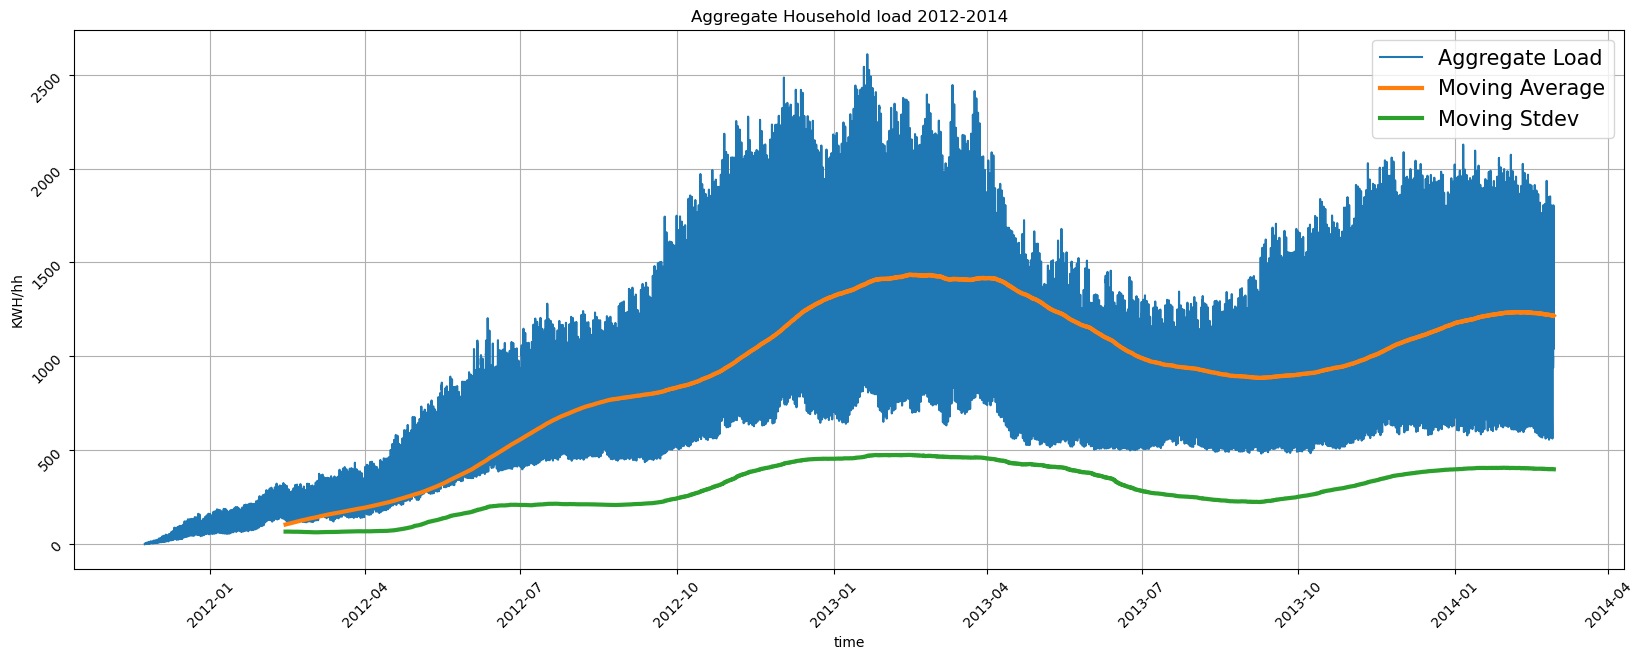

In [49]:
# Visualize aggregate load, moving average, moving standard deviation
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad, label="Aggregate Load")
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3, label="Moving Average")
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3, label="Moving Stdev")

ax.set(xlabel='time', ylabel='KWH/hh',
       title='Aggregate Household load 2012-2014',)
plt.tick_params(rotation=45)
ax.grid()

plt.legend(fontsize=15)
fig.savefig("Aggregate Household load 2012-2014.png")
plt.show()

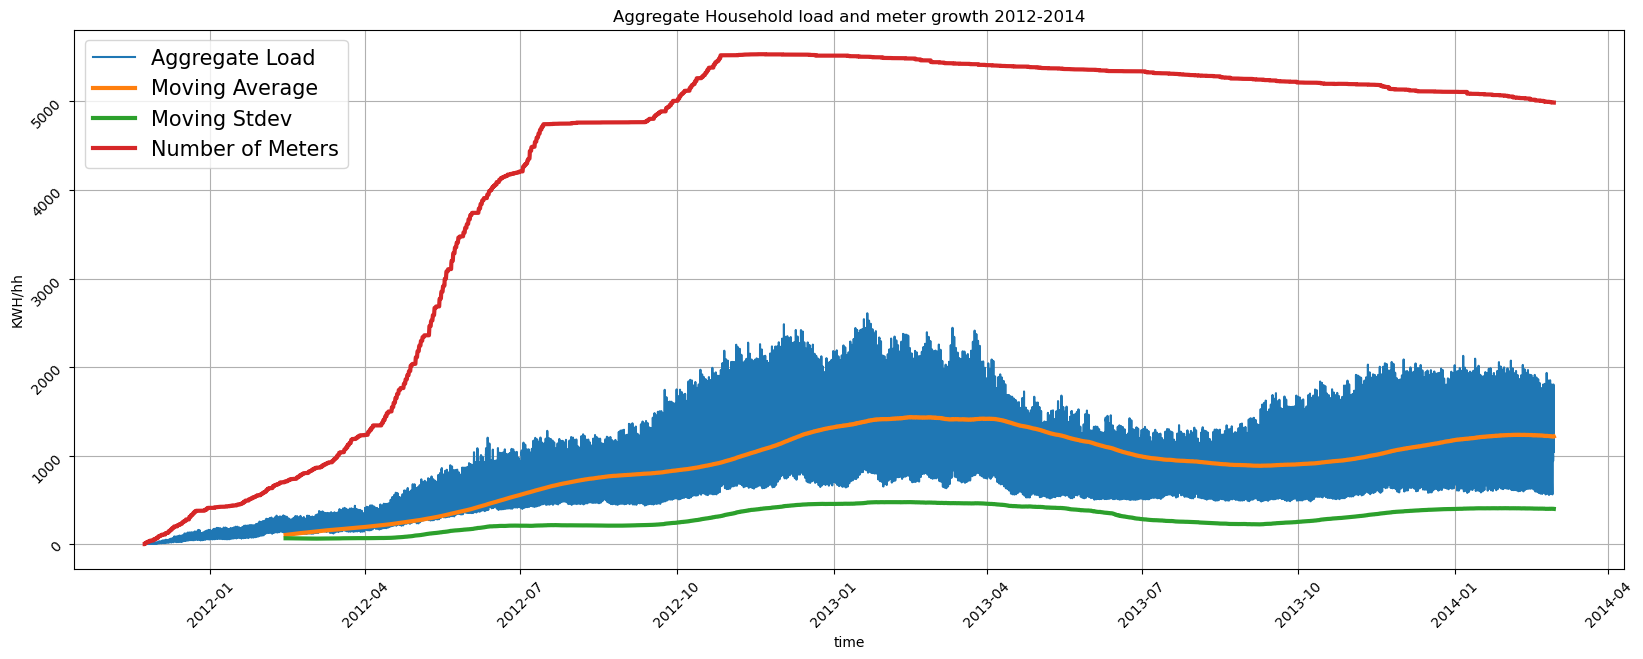

In [50]:
# Add number of meters to aggregate load, moving average, moving standard deviation
# This shows correlation of increased load with meters being added to the program during the recruitment period 
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad, label="Aggregate Load")
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3, label="Moving Average")
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3, label="Moving Stdev")
ax.plot(aggLoad.DateTime, aggLoad.numMeters, linewidth=3, label="Number of Meters")

ax.set(xlabel='time', ylabel='KWH/hh',
       title='Aggregate Household load and meter growth 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load and meter growth 2012-2014.png")
plt.legend(fontsize=15)
plt.show()

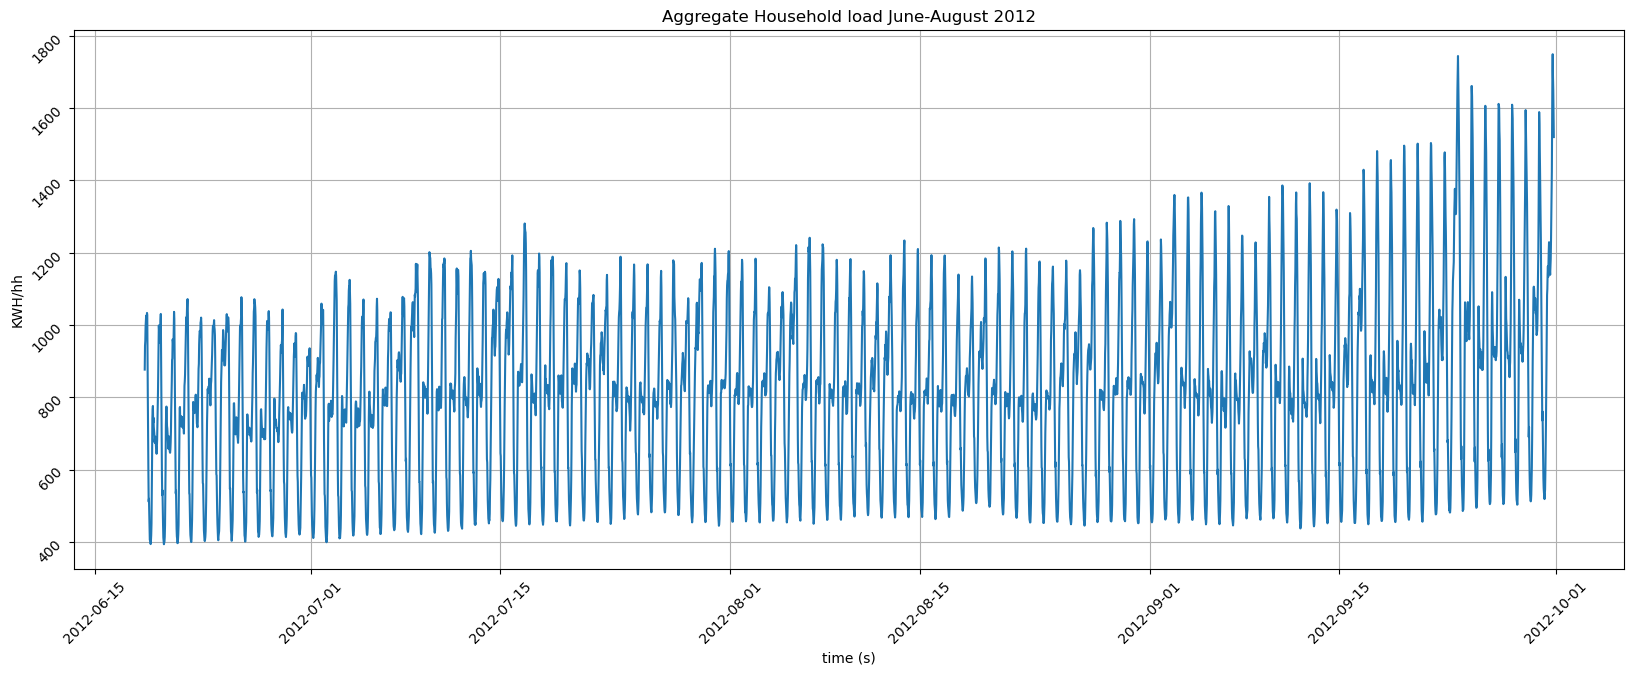

In [51]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load June-August 2012.png")
plt.show()

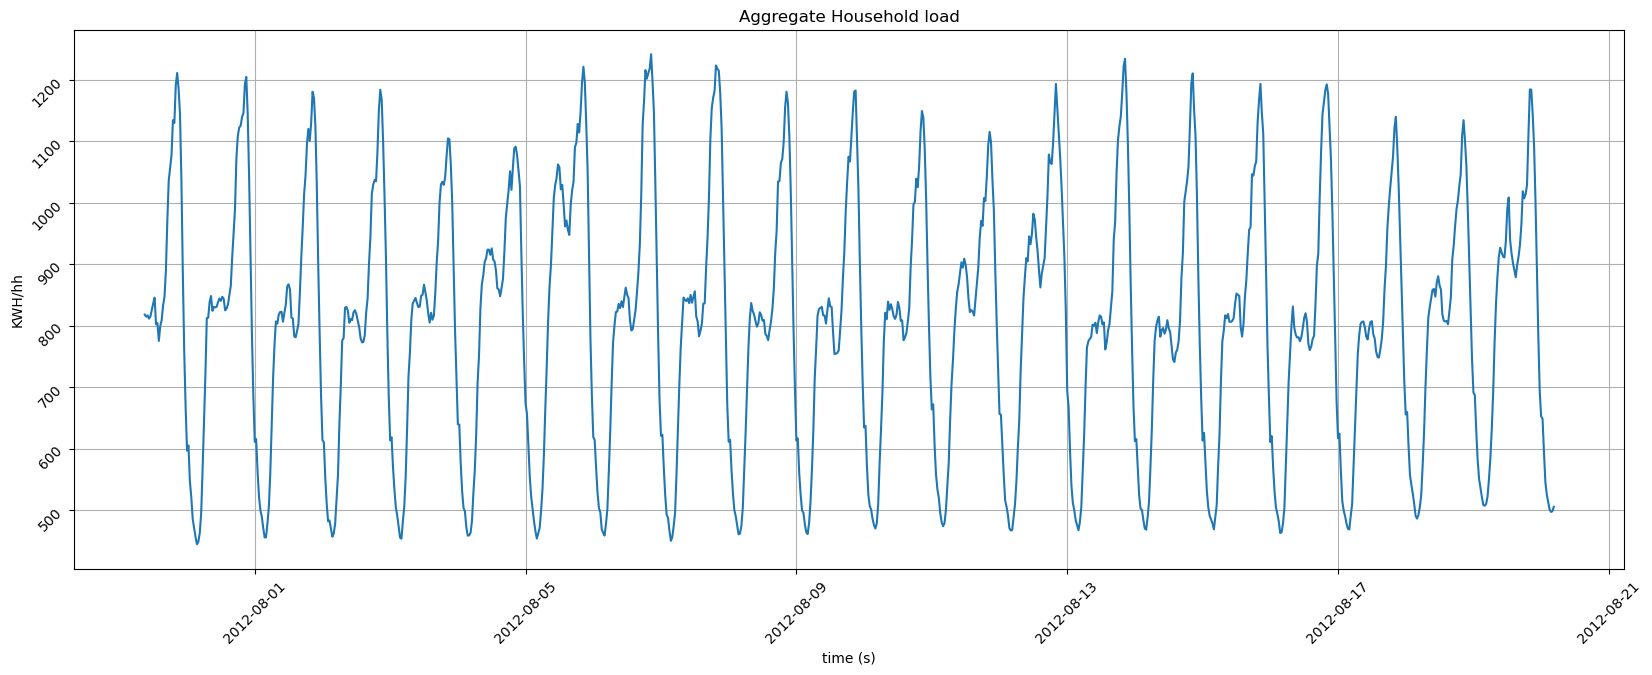

In [52]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load one month.png")
plt.show()

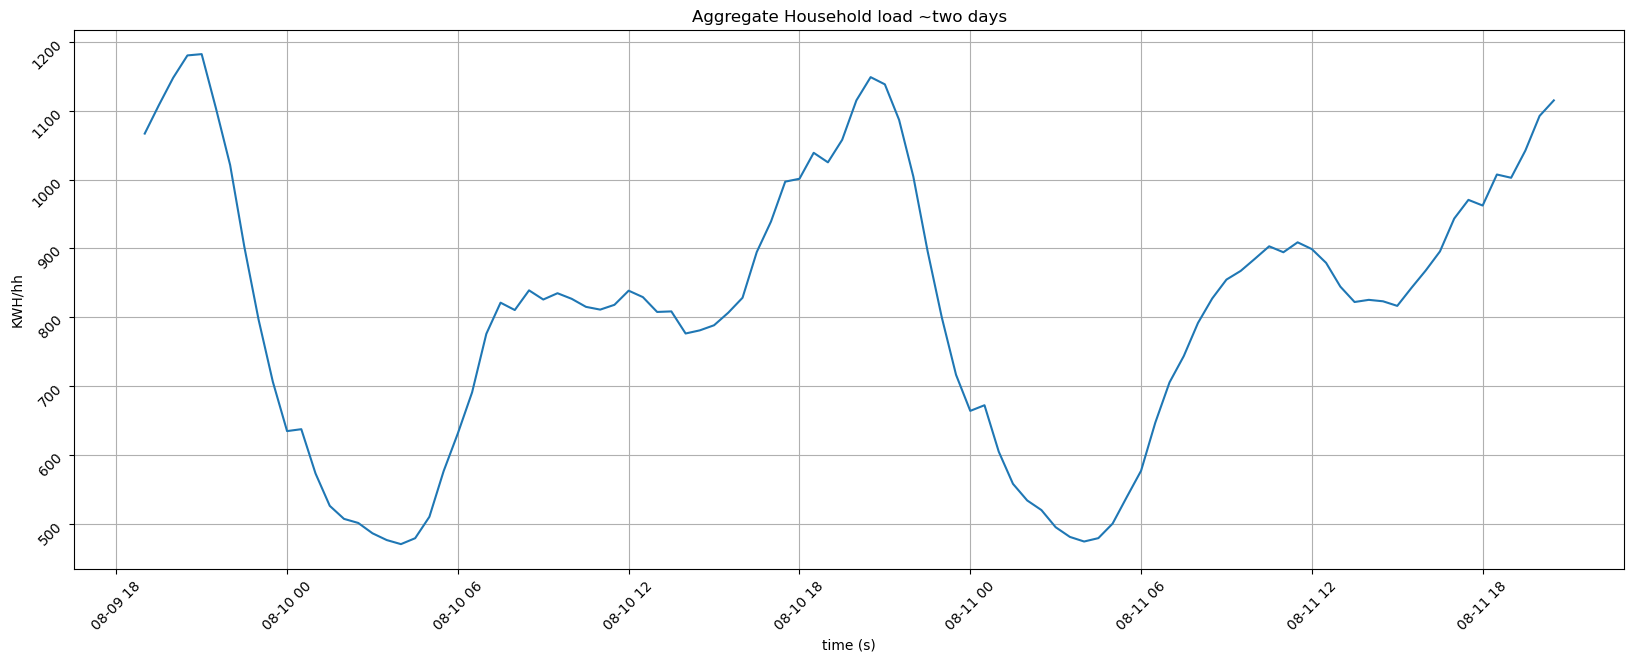

In [53]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load two days.png")
plt.show()

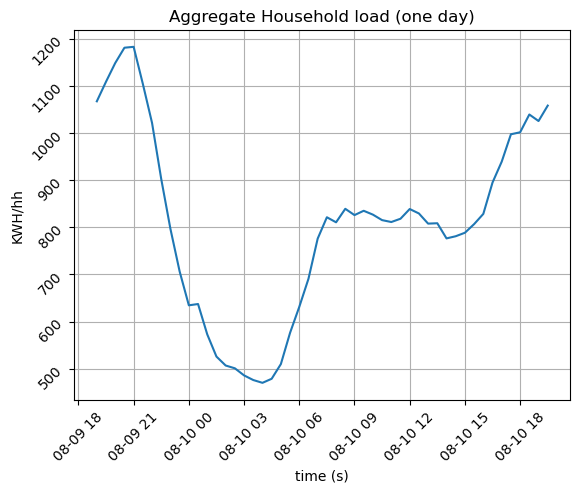

In [54]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load (one day).png")
plt.show()

In [55]:
aggLoad.to_csv('/kaggle/working/aggLoadDataFinal.csv',index=False)

In [56]:
aggLoad = pd.read_csv('/kaggle/working/aggLoadDataFinal.csv', parse_dates=["DateTime"])
aggLoad

AggregateLoad  numMeters            DateTime
0           0.569000          2 2011-11-23 09:00:00
1           0.561000          2 2011-11-23 09:30:00
2           0.920000          6 2011-11-23 10:00:00
3           0.588000          6 2011-11-23 10:30:00
4           0.772000          7 2011-11-23 11:00:00
...              ...        ...                 ...
39722    1494.829500       4987 2014-02-27 22:00:00
39723    1422.109001       4987 2014-02-27 22:30:00
39724    1258.090000       4987 2014-02-27 23:00:00
39725    1073.622001       4987 2014-02-27 23:30:00
39726    1042.266000       4987 2014-02-28 00:00:00

[39727 rows x 3 columns]

In [57]:
# Join load data and weather data
mergeData = pd.merge(aggLoad, weatherUpsample, on='DateTime', copy=False)
print(mergeData.info())
mergeData

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39727 entries, 0 to 39726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
 3   temperature    39727 non-null  float64       
 4   dewPoint       39727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.8 MB
None


AggregateLoad  numMeters            DateTime  temperature  dewPoint
0           0.569000          2 2011-11-23 09:00:00        4.840     4.680
1           0.561000          2 2011-11-23 09:30:00        5.290     5.070
2           0.920000          6 2011-11-23 10:00:00        5.740     5.460
3           0.588000          6 2011-11-23 10:30:00        6.705     5.600
4           0.772000          7 2011-11-23 11:00:00        7.670     5.740
...              ...        ...                 ...          ...       ...
39722    1494.829500       4987 2014-02-27 22:00:00        4.100     1.640
39723    1422.109001       4987 2014-02-27 22:30:00        4.015     1.625
39724    1258.090000       4987 2014-02-27 23:00:00        3.930     1.610
39725    1073.622001       4987 2014-02-27 23:30:00        3.870     1.570
39726    1042.266000       4987 2014-02-28 00:00:00        3.810     1.530

[39727 rows x 5 columns]

## Feature engineering

### Cyclical features

In [58]:
# Add features useful for time series
print(mergeData.info())
# Cyclical features
# week of year
weekOfYear = mergeData.DateTime.dt.weekofyear
mergeData["weekOfYear_sin"] = np.sin(weekOfYear*(2.*np.pi/52))
mergeData["weekOfYear_cos"] = np.cos(weekOfYear*(2.*np.pi/52))
# day of week
dayOfWeek = mergeData.DateTime.dt.dayofweek
mergeData["dayOfWeek_sin"] = np.sin(dayOfWeek*(2.*np.pi/7))
mergeData["dayOfWeek_cos"] = np.cos(dayOfWeek*(2.*np.pi/7))
# day of year
# aggLoad["dayOfYear"] = aggLoad.DateTime.dt.dayofyear
# minute of the day
minuteOfDay = (mergeData.DateTime.dt.hour * 60) + mergeData.DateTime.dt.minute
mergeData["minuteOfDay_sin"] = np.sin(minuteOfDay*(2.*np.pi/48))
mergeData["minuteOfDay_cos"] = np.cos(minuteOfDay*(2.*np.pi/48))

cyclicalFeatureNames = ['dayOfWeek_sin', 'dayOfWeek_cos', 'minuteOfDay_sin', 'minuteOfDay_cos', 'weekOfYear_sin', 'weekOfYear_cos']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39727 entries, 0 to 39726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
 3   temperature    39727 non-null  float64       
 4   dewPoint       39727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.8 MB
None


## Decomposition features

In [59]:
decomp_df = pd.DataFrame(mergeData.copy())
decomp_df = decomp_df.set_index(pd.DatetimeIndex(decomp_df['DateTime']))
decomp_df.index=decomp_df.DateTime
decomp_df = decomp_df.AggregateLoad
print(decomp_df.describe())
print(decomp_df.info)

count    39727.000000
mean       896.369164
std        518.309150
min          0.561000
25%        533.251967
50%        876.796386
75%       1222.138521
max       2608.409794
Name: AggregateLoad, dtype: float64
<bound method Series.info of DateTime
2011-11-23 09:00:00       0.569000
2011-11-23 09:30:00       0.561000
2011-11-23 10:00:00       0.920000
2011-11-23 10:30:00       0.588000
2011-11-23 11:00:00       0.772000
                          ...     
2014-02-27 22:00:00    1494.829500
2014-02-27 22:30:00    1422.109001
2014-02-27 23:00:00    1258.090000
2014-02-27 23:30:00    1073.622001
2014-02-28 00:00:00    1042.266000
Name: AggregateLoad, Length: 39727, dtype: float64>


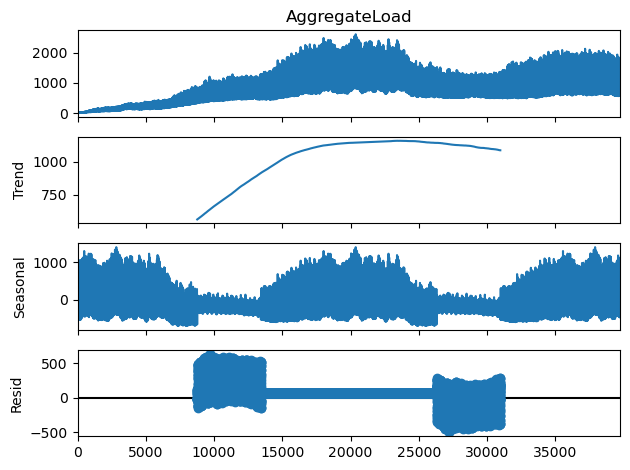

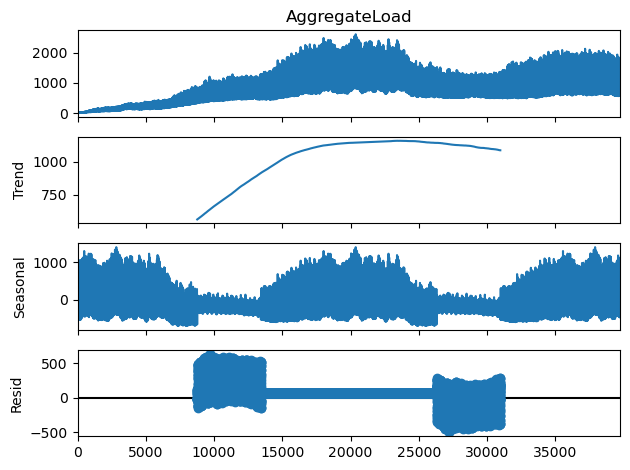

In [60]:
# Annual decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
yearly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=17532)
mergeData['yearlySeasonal']=yearly_seasonal_decomp.seasonal
yearly_seasonal_decomp.plot()

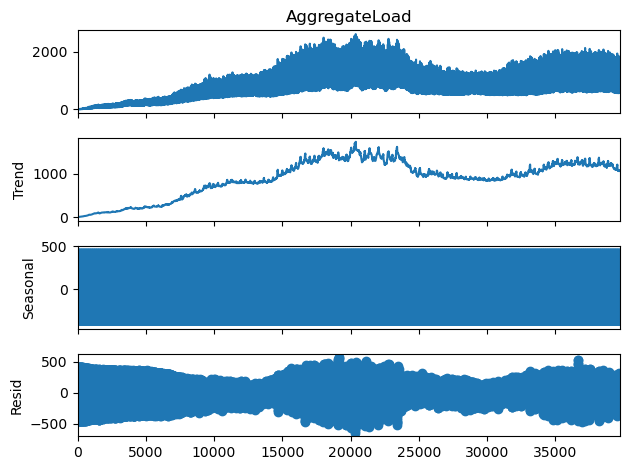

In [61]:
# daily decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
daily_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=48)
mergeData['dailyTrend']=daily_seasonal_decomp.trend
mergeData['dailySeasonal']=daily_seasonal_decomp.seasonal
mergeData['dailyResid']=daily_seasonal_decomp.resid
daily_seasonal_decomp.plot();

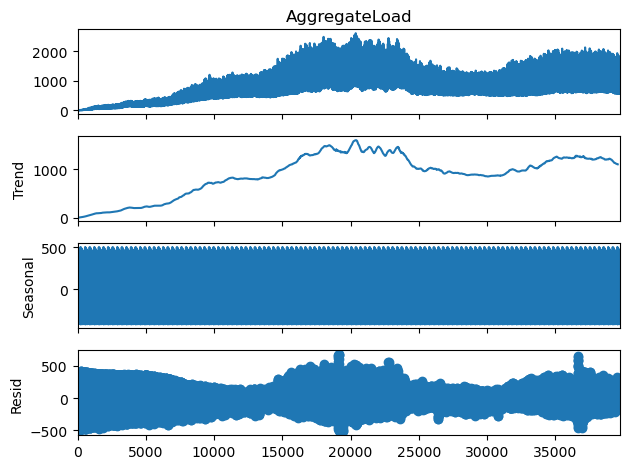

In [62]:
# weekly decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_seasonal_decomp = seasonal_decompose(mergeData['AggregateLoad'], period=336)
mergeData['weeklyTrend']=weekly_seasonal_decomp.trend
mergeData['weeklySeasonal']=weekly_seasonal_decomp.seasonal
mergeData['weeklyResid']=weekly_seasonal_decomp.resid
weekly_seasonal_decomp.plot();

### Lag features

In [63]:
# load 1 day lag
oneDayPeriods = 48
mergeData['AggregateLoad_1dayLag'] = mergeData['AggregateLoad'].shift(oneDayPeriods)
# load 1 week lag
oneWeekPeriods = oneDayPeriods * 7
mergeData['AggregateLoad_1weekLag'] = mergeData['AggregateLoad'].shift(oneWeekPeriods)

# load change from last half-hour to this half-hour
mergeData['AggregateLoad_halfhourdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(1)
# load change from one week ago to this half-hour
mergeData['AggregateLoad_weekdiff'] = mergeData['AggregateLoad'] - mergeData['AggregateLoad'].shift(oneWeekPeriods)

print(mergeData.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39727 entries, 0 to 39726
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   AggregateLoad               39727 non-null  float64       
 1   numMeters                   39727 non-null  int64         
 2   DateTime                    39727 non-null  datetime64[ns]
 3   temperature                 39727 non-null  float64       
 4   dewPoint                    39727 non-null  float64       
 5   weekOfYear_sin              39727 non-null  float64       
 6   weekOfYear_cos              39727 non-null  float64       
 7   dayOfWeek_sin               39727 non-null  float64       
 8   dayOfWeek_cos               39727 non-null  float64       
 9   minuteOfDay_sin             39727 non-null  float64       
 10  minuteOfDay_cos             39727 non-null  float64       
 11  yearlySeasonal              39727 non-null  float64   

In [64]:
# drop NaNs created by feature engineering
mergeData.dropna(inplace=True)

In [65]:
# temperature change from last half-hour to this half-hour
# eliminated due to permutation feature importance
# weatherUpsample['temp_halfhourdiff'] = weatherUpsample['temperature'] - weatherUpsample['temperature'].shift(1)

# max temp for the day
mergeData['temp_daymax'] = mergeData.groupby(mergeData.DateTime.dt.date)['temperature'].transform('max')
mergeData['temp_daymin'] = mergeData.groupby(weatherUpsample.DateTime.dt.date)['temperature'].transform('min')
print(mergeData['temp_daymax'])
print(mergeData['temp_daymin'])

336      11.87
337      11.87
338      11.87
339      11.87
340      11.87
         ...  
39554    13.07
39555    13.07
39556    13.07
39557    13.07
39558    13.07
Name: temp_daymax, Length: 39223, dtype: float64
336      7.66
337      7.66
338      7.66
339      7.66
340      7.66
         ... 
39554    9.22
39555    9.22
39556    9.22
39557    9.22
39558    9.22
Name: temp_daymin, Length: 39223, dtype: float64


In [66]:
"""
# Find the earliest date when there is the maximum number of meters contributing to the aggregate load
# will disreard all data beofre this point
maxMeters = aggLoad['numMeters'].max()
print(maxMeters)
startDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()
print(startDateTime)
startDate = startDateTime.date()
print(startDate)
"""

"\n# Find the earliest date when there is the maximum number of meters contributing to the aggregate load\n# will disreard all data beofre this point\nmaxMeters = aggLoad['numMeters'].max()\nprint(maxMeters)\nstartDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()\nprint(startDateTime)\nstartDate = startDateTime.date()\nprint(startDate)\n"

In [67]:
# Move first column to the Last
# df = pd.DataFrame(mergeData)
df = mergeData
temp_cols=df.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
mergeData=df[new_cols]
print(mergeData)

       numMeters            DateTime  temperature  dewPoint  weekOfYear_sin  \
336           64 2011-11-30 09:00:00        7.660     4.960       -0.464723   
337           66 2011-11-30 09:30:00        8.695     5.475       -0.464723   
338           69 2011-11-30 10:00:00        9.730     5.990       -0.464723   
339           70 2011-11-30 10:30:00       10.510     6.040       -0.464723   
340           70 2011-11-30 11:00:00       11.290     6.090       -0.464723   
...          ...                 ...          ...       ...             ...   
39554       4996 2014-02-24 10:00:00       11.320     6.260        0.885456   
39555       4996 2014-02-24 10:30:00       11.890     6.055        0.885456   
39556       4996 2014-02-24 11:00:00       12.460     5.850        0.885456   
39557       4996 2014-02-24 11:30:00       12.765     6.215        0.885456   
39558       4996 2014-02-24 12:00:00       13.070     6.580        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos

In [68]:
from pandas_profiling import ProfileReport

profile = ProfileReport(mergeData, tsmode=True, sortby="DateTime")
profile.to_file('mergeData profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
# Remove the dateTime feature from the dataset (we've extracted to features we need from it)
print(mergeData)
mergeData.drop(columns=['DateTime'], inplace=True)

       numMeters            DateTime  temperature  dewPoint  weekOfYear_sin  \
336           64 2011-11-30 09:00:00        7.660     4.960       -0.464723   
337           66 2011-11-30 09:30:00        8.695     5.475       -0.464723   
338           69 2011-11-30 10:00:00        9.730     5.990       -0.464723   
339           70 2011-11-30 10:30:00       10.510     6.040       -0.464723   
340           70 2011-11-30 11:00:00       11.290     6.090       -0.464723   
...          ...                 ...          ...       ...             ...   
39554       4996 2014-02-24 10:00:00       11.320     6.260        0.885456   
39555       4996 2014-02-24 10:30:00       11.890     6.055        0.885456   
39556       4996 2014-02-24 11:00:00       12.460     5.850        0.885456   
39557       4996 2014-02-24 11:30:00       12.765     6.215        0.885456   
39558       4996 2014-02-24 12:00:00       13.070     6.580        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos

## Plot autocorrelation of aggregate load (target) to investigate cyclical properties

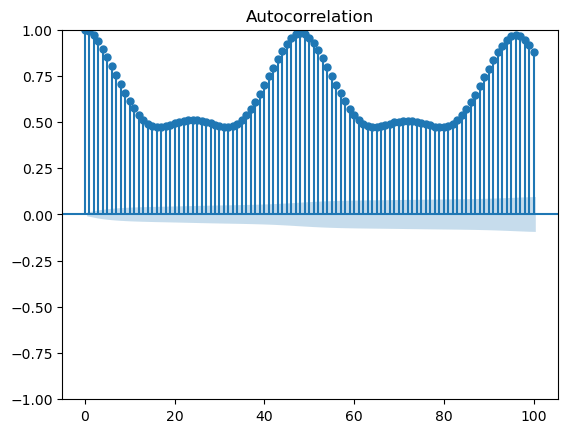

In [70]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract the AggregateLoad feature
aggregate_load = mergeData['AggregateLoad']

# Plot the autocorrelation plot
plot_acf(aggregate_load, lags=100)

# Show the plot
plt.show()

In [71]:
mergeData.to_csv('/kaggle/working/mergeDataFeatureCandidates.csv',index=False)

In [72]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFeatureCandidates.csv')
mergeData

numMeters  temperature  dewPoint  weekOfYear_sin  weekOfYear_cos  \
0             64        7.660     4.960       -0.464723        0.885456   
1             66        8.695     5.475       -0.464723        0.885456   
2             69        9.730     5.990       -0.464723        0.885456   
3             70       10.510     6.040       -0.464723        0.885456   
4             70       11.290     6.090       -0.464723        0.885456   
...          ...          ...       ...             ...             ...   
39218       4996       11.320     6.260        0.885456        0.464723   
39219       4996       11.890     6.055        0.885456        0.464723   
39220       4996       12.460     5.850        0.885456        0.464723   
39221       4996       12.765     6.215        0.885456        0.464723   
39222       4996       13.070     6.580        0.885456        0.464723   

       dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  \
0           0.974928      -0.222521     1.000000e+00     9.790985e-16   
1           0.974928      -0.222521    -7.071068e-01     7.071068e-01   
2           0.974928      -0.222521     1.371976e-14    -1.000000e+00   
3           0.974928      -0.222521     7.071068e-01     7.071068e-01   
4           0.974928      -0.222521    -1.000000e+00    -1.224956e-14   
...              ...            ...              ...              ...   
39218       0.000000       1.000000     1.371976e-14    -1.000000e+00   
39219       0.000000       1.000000     7.071068e-01     7.071068e-01   
39220       0.000000       1.000000    -1.000000e+00    -1.224956e-14   
39221       0.000000       1.000000     7.071068e-01    -7.071068e-01   
39222       0.000000       1.000000    -1.077937e-14     1.000000e+00   

       yearlySeasonal  ...  weeklyTrend  weeklySeasonal  weeklyResid  \
0           43.209702  ...    15.344628       -3.517150    -0.876478   
1           90.896703  ...    15.411506      -18.413807    15.918301   
2          227.575081  ...    15.471085      -32.990513    29.963428   
3          477.915041  ...    15.524232      -42.123696    38.922464   
4          708.690667  ...    15.568824      -45.024905    40.149581   
...               ...  ...          ...             ...          ...   
39218     -404.721545  ...  1102.178691       -9.128025   -53.183671   
39219     -411.773097  ...  1102.260395      -16.579063   -61.693846   
39220     -412.170203  ...  1102.331858      -22.963748   -82.407635   
39221     -388.306826  ...  1102.308509      -17.737587  -106.821457   
39222     -368.614274  ...  1102.198442      -13.505024  -106.718797   

       AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0                   9.500000                0.569000   
1                   8.304000                0.561000   
2                   9.475000                0.920000   
3                  10.045000                0.588000   
4                   9.096000                0.772000   
...                      ...                     ...   
39218            1262.133219             1166.933389   
39219            1284.125044             1145.325656   
39220            1290.955870             1144.804591   
39221            1343.646697             1141.465524   
39222            1364.942521             1127.796459   

       AggregateLoad_halfhourdiff  AggregateLoad_weekdiff  temp_daymax  \
0                        0.134000               10.382000        11.87   
1                        1.965000               12.355000        11.87   
2                       -0.472000               11.524000        11.87   
3                       -0.121000               11.735000        11.87   
4                       -1.629500                9.921500        11.87   
...                           ...                     ...          ...   
39218                  -26.388344             -127.066393        13.07   
39219                  -15.879510             -121.338171        13.07   
39220                  -2

## Final feature selection

In [73]:
# select features
# mergeData = mergeData[['AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'dayOfWeek', 'temperature','AggregateLoad']]
# mergeData = mergeData[['numMeters', 'temperature', 'minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['numMeters', 'minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['AggregateLoad']]
# remove features dues to feature permutation importance
# mergeData.drop(columns=['numMeters', 'yearlySeasonal'], inplace=True)
# mergeData.drop(columns=['temperature', 'AggregateLoad_1weekLag', 'temp_daymax'], inplace=True)
# after looking at correlation matrix and hearing about overalp between cyclical encoding and seasinal decomp...
# mergeData.drop(columns=['dewPoint', 'dayOfWeek_sin', 'minuteOfDay_sin', 'minuteOfDay_cos', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'temp_daymin', 'AggregateLoad_1dayLag'], inplace=True)
# ok have to put those cyclical features back in...
# mergeData.drop(columns=['dewPoint', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'temp_daymin', 'AggregateLoad_1dayLag'], inplace=True)
# ok now drop these after feature importance...
# mergeData.drop(columns=['yearlySeasonal', 'numMeters', 'minuteOfDay_sin', 'minuteOfDay_cos', 'AggregateLoad_weekdiff'], inplace=True)

# going back to best feature set
mergeData = mergeData[['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'dailyTrend', 'dailySeasonal', 'dailyResid', 'weeklyTrend', 'weeklySeasonal', 'weeklyResid', 'AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'AggregateLoad_halfhourdiff', 'temperature', 'temp_daymax', 'AggregateLoad']]

mergeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39223 entries, 0 to 39222
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              39223 non-null  float64
 1   weekOfYear_cos              39223 non-null  float64
 2   dayOfWeek_sin               39223 non-null  float64
 3   dayOfWeek_cos               39223 non-null  float64
 4   dailyTrend                  39223 non-null  float64
 5   dailySeasonal               39223 non-null  float64
 6   dailyResid                  39223 non-null  float64
 7   weeklyTrend                 39223 non-null  float64
 8   weeklySeasonal              39223 non-null  float64
 9   weeklyResid                 39223 non-null  float64
 10  AggregateLoad_1dayLag       39223 non-null  float64
 11  AggregateLoad_1weekLag      39223 non-null  float64
 12  AggregateLoad_halfhourdiff  39223 non-null  float64
 13  temperature                 392

In [74]:
# mergeData.drop(columns=['dewPoint', 'minuteOfDay_sin', 'minuteOfDay_cos', 'temp_daymin', 'AggregateLoad_weekdiff'], inplace=True)
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39223 entries, 0 to 39222
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              39223 non-null  float64
 1   weekOfYear_cos              39223 non-null  float64
 2   dayOfWeek_sin               39223 non-null  float64
 3   dayOfWeek_cos               39223 non-null  float64
 4   dailyTrend                  39223 non-null  float64
 5   dailySeasonal               39223 non-null  float64
 6   dailyResid                  39223 non-null  float64
 7   weeklyTrend                 39223 non-null  float64
 8   weeklySeasonal              39223 non-null  float64
 9   weeklyResid                 39223 non-null  float64
 10  AggregateLoad_1dayLag       39223 non-null  float64
 11  AggregateLoad_1weekLag      39223 non-null  float64
 12  AggregateLoad_halfhourdiff  39223 non-null  float64
 13  temperature                 392

In [75]:
mergeData.to_csv('/kaggle/working/mergeDataFinal.csv',index=False)

In [76]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFinal.csv')
mergeData

weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  \
0           -0.464723        0.885456       0.974928      -0.222521   
1           -0.464723        0.885456       0.974928      -0.222521   
2           -0.464723        0.885456       0.974928      -0.222521   
3           -0.464723        0.885456       0.974928      -0.222521   
4           -0.464723        0.885456       0.974928      -0.222521   
...               ...             ...            ...            ...   
39218        0.885456        0.464723       0.000000       1.000000   
39219        0.885456        0.464723       0.000000       1.000000   
39220        0.885456        0.464723       0.000000       1.000000   
39221        0.885456        0.464723       0.000000       1.000000   
39222        0.885456        0.464723       0.000000       1.000000   

        dailyTrend  dailySeasonal  dailyResid  weeklyTrend  weeklySeasonal  \
0        13.699760      17.604790  -20.353550    15.344628       -3.517150   
1        13.788406      15.719849  -16.592255    15.411506      -18.413807   
2        13.842333      11.024520  -12.422854    15.471085      -32.990513   
3        13.869135       7.349837   -8.895972    15.524232      -42.123696   
4        13.923563       7.485270  -10.715332    15.568824      -45.024905   
...            ...            ...         ...          ...             ...   
39218  1086.726060      11.024520  -57.883584  1102.178691       -9.128025   
39219  1085.785208       7.349837  -69.147559  1102.260395      -16.579063   
39220  1085.043054       7.485270  -95.567849  1102.331858      -22.963748   
39221  1084.517179      12.996418 -119.764132  1102.308509      -17.737587   
39222  1083.905137      17.191010 -119.121527  1102.198442      -13.505024   

       weeklyResid  AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0        -0.876478               9.500000                0.569000   
1        15.918301               8.304000                0.561000   
2        29.963428               9.475000                0.920000   
3        38.922464              10.045000                0.588000   
4        40.149581               9.096000                0.772000   
...            ...                    ...                     ...   
39218   -53.183671            1262.133219             1166.933389   
39219   -61.693846            1284.125044             1145.325656   
39220   -82.407635            1290.955870             1144.804591   
39221  -106.821457            1343.646697             1141.465524   
39222  -106.718797            1364.942521             1127.796459   

       AggregateLoad_halfhourdiff  temperature  temp_daymax  AggregateLoad  
0                        0.134000        7.660        11.87      10.951000  
1                        1.965000        8.695        11.87      12.916000  
2                       -0.472000        9.730        11.87      12.444000  
3                       -0.121000       10.510        11.87      12.323000  
4                       -1.629500       11.290        11.87      10.693500  
...                           ...          ...          ...            ...  
39218                  -26.388344       11.320        13.07    1039.866996  
39219                  -15.879510       11.890        13.07    1023.987486  
39220                  -27.027011       12.460        13.07     996.960474  
39221                  -19.211009       12.765        13.07     977.749466  
39222                    4.225155       13.070        13.07     981.974620  

[39223 rows x 16 columns]

In [77]:
# profile = ProfileReport(mergeDataFinal, tsmode=True, sortby="time")
# profile.to_file('mergeDataFinal profile_report.html')

## Training, Validation, Testing Split

In [78]:
# Split the time series data into train, test, and validation datasets
train_size = int(len(mergeData) * 0.7)  # 70% for training
val_size = int(len(mergeData) * 0.2)   # 20% for validation
test_size = len(mergeData) - val_size - train_size  # Remaining 10% for testing

train_data = mergeData[:train_size].copy()
train_data.reset_index(drop=True, inplace=True)
val_data = mergeData[train_size:train_size+val_size].copy()
val_data.reset_index(drop=True, inplace=True)
test_data = mergeData[train_size+val_size:].copy()
test_data.reset_index(drop=True, inplace=True)

print('\ntrain_data.head()\n', train_data.head())
print(train_data.info())
print('\nval_data.head()\n', val_data.head())
print(val_data.info())
print('\ntest_data.head()\n', test_data.head())
print(test_data.info())

num_out_features = mergeData.shape[1]
label_columns = ['AggregateLoad']


train_data.head()
    weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  dailyTrend  \
0       -0.464723        0.885456       0.974928      -0.222521   13.699760   
1       -0.464723        0.885456       0.974928      -0.222521   13.788406   
2       -0.464723        0.885456       0.974928      -0.222521   13.842333   
3       -0.464723        0.885456       0.974928      -0.222521   13.869135   
4       -0.464723        0.885456       0.974928      -0.222521   13.923563   

   dailySeasonal  dailyResid  weeklyTrend  weeklySeasonal  weeklyResid  \
0      17.604790  -20.353550    15.344628       -3.517150    -0.876478   
1      15.719849  -16.592255    15.411506      -18.413807    15.918301   
2      11.024520  -12.422854    15.471085      -32.990513    29.963428   
3       7.349837   -8.895972    15.524232      -42.123696    38.922464   
4       7.485270  -10.715332    15.568824      -45.024905    40.149581   

   AggregateLoad_1dayLag  AggregateLoad_1weekLag  AggregateL

In [79]:
def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('KWH per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

## Standardize the data

In [80]:
# Standardize the data
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

mergeDataNormed = (mergeData - train_mean) / train_std

In [81]:
train_data.to_csv('/kaggle/working/train_data.csv',index=False)
val_data.to_csv('/kaggle/working/val_data.csv',index=False)
test_data.to_csv('/kaggle/working/test_data.csv',index=False)
mergeDataNormed.to_csv('/kaggle/working/mergeDataNormed.csv',index=False)

In [82]:
train_data = pd.read_csv('/kaggle/working/train_data.csv')
val_data = pd.read_csv('/kaggle/working/val_data.csv')
test_data = pd.read_csv('/kaggle/working/test_data.csv')
mergeDataNormed = pd.read_csv('/kaggle/working/mergeDataNormed.csv')
label_columns = ['AggregateLoad']

In [83]:
print(train_data.info())
print(val_data.info())
print(test_data.info())
print(mergeDataNormed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27456 entries, 0 to 27455
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weekOfYear_sin              27456 non-null  float64
 1   weekOfYear_cos              27456 non-null  float64
 2   dayOfWeek_sin               27456 non-null  float64
 3   dayOfWeek_cos               27456 non-null  float64
 4   dailyTrend                  27456 non-null  float64
 5   dailySeasonal               27456 non-null  float64
 6   dailyResid                  27456 non-null  float64
 7   weeklyTrend                 27456 non-null  float64
 8   weeklySeasonal              27456 non-null  float64
 9   weeklyResid                 27456 non-null  float64
 10  AggregateLoad_1dayLag       27456 non-null  float64
 11  AggregateLoad_1weekLag      27456 non-null  float64
 12  AggregateLoad_halfhourdiff  27456 non-null  float64
 13  temperature                 274

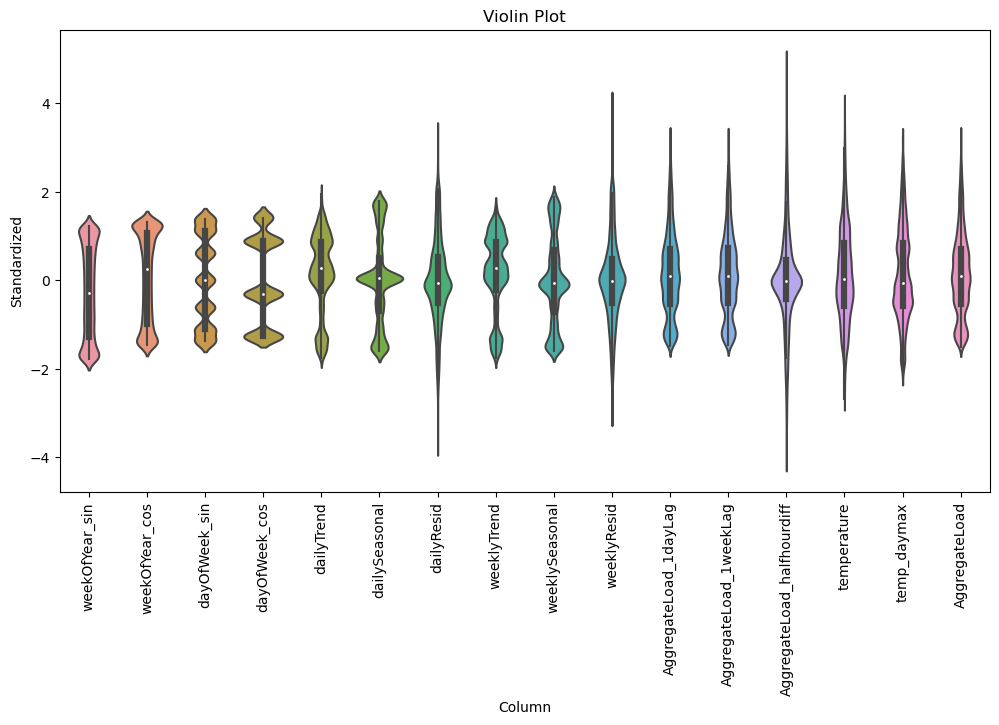

In [84]:
# Visualize distribution of the features
# df_std = (mergeData - train_mean) / train_std
df_std = mergeDataNormed.melt(var_name='Column', value_name='Standardized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Standardized', data=df_std)
_ = ax.set_xticklabels(mergeDataNormed.keys(), rotation=90)
plt.title('Violin Plot')
plt.savefig('violin_plot.png', format='png')


In [85]:
import numpy as np
import pandas as pd
from sklearn.metrics import mutual_info_score

# Split the data into features and target
X = mergeDataNormed.drop(columns=['AggregateLoad'])
y = mergeDataNormed['AggregateLoad']

# Calculate mutual information between each feature and the target variable
mutual_information_scores = []
for feature in X.columns:
    mutual_information_score = mutual_info_score(X[feature], y)
    mutual_information_scores.append([feature,mutual_information_score])
    
MISdf = pd.DataFrame(mutual_information_scores, columns=['Feature', 'Mutual information score'])
# Print the mutual information scores
# print('Mutual information scores:', mutual_information_scores)
print(MISdf.sort_values('Mutual information score', ascending=False))


                       Feature  Mutual information score
4                   dailyTrend                 10.576700
6                   dailyResid                 10.576700
7                  weeklyTrend                 10.576700
9                  weeklyResid                 10.576700
12  AggregateLoad_halfhourdiff                 10.576524
10       AggregateLoad_1dayLag                 10.576382
11      AggregateLoad_1weekLag                 10.576312
13                 temperature                  8.320722
14                 temp_daymax                  6.456673
8               weeklySeasonal                  5.816786
5                dailySeasonal                  3.870883
0               weekOfYear_sin                  3.767587
1               weekOfYear_cos                  3.691694
2                dayOfWeek_sin                  1.945623
3                dayOfWeek_cos                  1.945623


In [86]:
from pandas_profiling import ProfileReport

# profile = ProfileReport(mergeDataNormed, tsmode=True, sortby=mergeDataNormed.index.astype(int))
profile = ProfileReport(mergeDataNormed, tsmode=True)
profile.to_file('mergeDataNormed profile_report.html')
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Functions for preparing data for time series machine learning

Not my work

Credit to [Tensorflow Tutorial: Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [87]:
class WindowGenerator():
    # https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    # print('\nWindowGenerator.__init__\n')
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    # print('\nlabel_columns:\n', label_columns)
    # Work out the label column indices.
    self.label_columns = label_columns
    self.num_out_features = train_df.shape[1] # default to predicting all input columns
    
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
      self.num_out_features = len(label_columns) # JS added this
      # print('\nself.num_out_features:', self.num_out_features)
      
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [88]:
def split_window(self, features):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#2_split
  # print('\nsplit_window\n', features)
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [89]:
def plot(self, model=None, plot_col='AggregateLoad', max_subplots=3):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#3_plot
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [90]:
def make_dataset(self, data):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
  # print('\nmake_dataset\n', data)
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      seed=randomState,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [91]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Create data windows for time series forecasting

Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label column name(s): ['AggregateLoad']

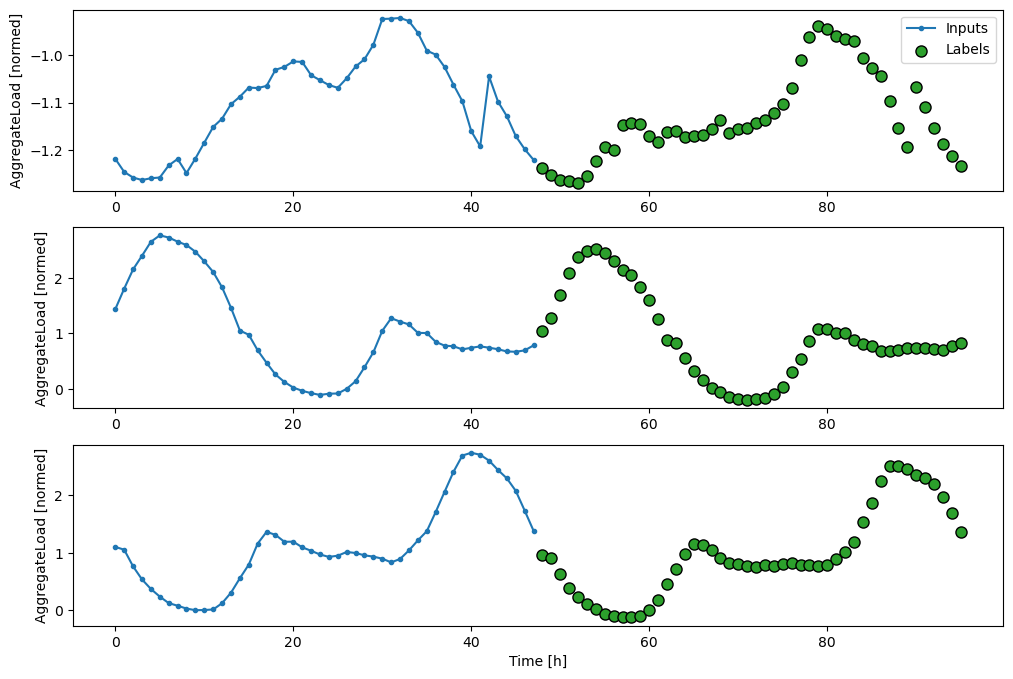

In [92]:
# Prepare data for one-shot multi-step
OUT_STEPS = 48 # 24 hour forecast
# IN_STEPS = 336 # look back 1 week
IN_STEPS = 48 # look back 1 day
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['AggregateLoad'],
                              train_df=train_data, val_df=val_data, test_df=test_data,)

num_out_features = multi_window.num_out_features
# print('\nnum_out_features: ', num_out_features)
multi_window.plot()
multi_window

# Build and Train models

## Baseline persistence model

Use a 1 week naive persistence model as a baseline to evaluate performance of the machine learning models we are building

Georgios Tziolis, Chrysovalantis Spanias, Maria Theodoride, Spyros Theocharides, Javier Lopez-Lorente, Andreas Livera, George Makrides, George E. Georghiou,

Short-term electric net load forecasting for solar-integrated distribution systems based on Bayesian neural networks and statistical post-processing,

Energy,
Volume 271,
2023,
127018,
ISSN 0360-5442,

https://doi.org/10.1016/j.energy.2023.127018.

In [93]:
# capture performnce of models
multi_val_performance = {}
multi_test_performance = {}

### Function to compile and fit models

In [94]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  # https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  checkpoint_filepath = '/tmp/' + model.name + '/checkpoint'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)
    
  # print('\nwindow.train:\n', window.train)  
  # print('\nwindow.val:\n', window.val)  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, checkpoint])

  # restore weights from epoch with best loss against validation dataset
  model.load_weights(checkpoint_filepath)
    
  return history


In [95]:
# Baseline Model: Naive 1 week persistence
OneWeekNPeriods = 48 * 7
NaiveForecast = mergeData.AggregateLoad.shift(OneWeekNPeriods).copy()

print(NaiveForecast.info())
print(NaiveForecast.describe())

<class 'pandas.core.series.Series'>
RangeIndex: 39223 entries, 0 to 39222
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
38887 non-null  float64
dtypes: float64(1)
memory usage: 306.6 KB
None
count    38887.000000
mean       901.145672
std        515.040510
min          7.664000
25%        537.285350
50%        878.142433
75%       1224.538267
max       2608.409794
Name: AggregateLoad, dtype: float64


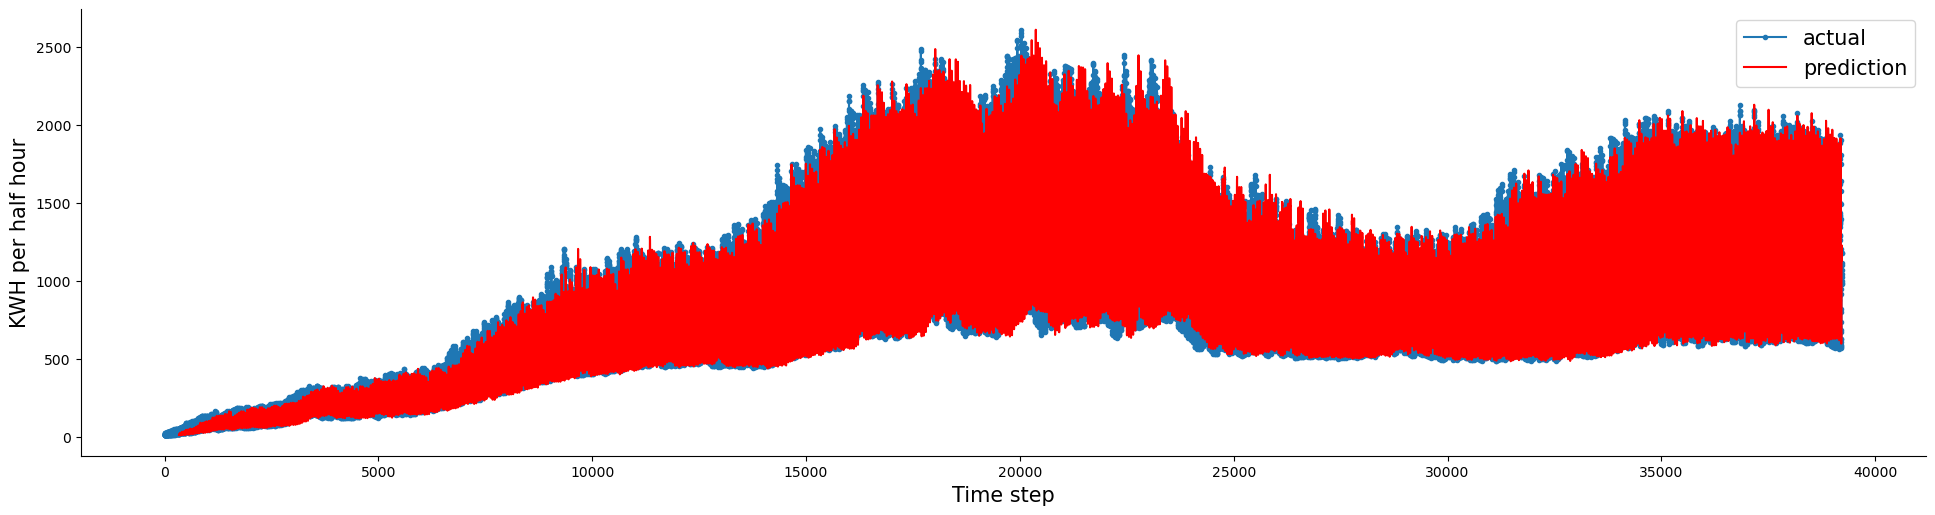

In [96]:
# visualize naive forecast and actuals for entire dataset
prediction_plot(mergeData.AggregateLoad, NaiveForecast)

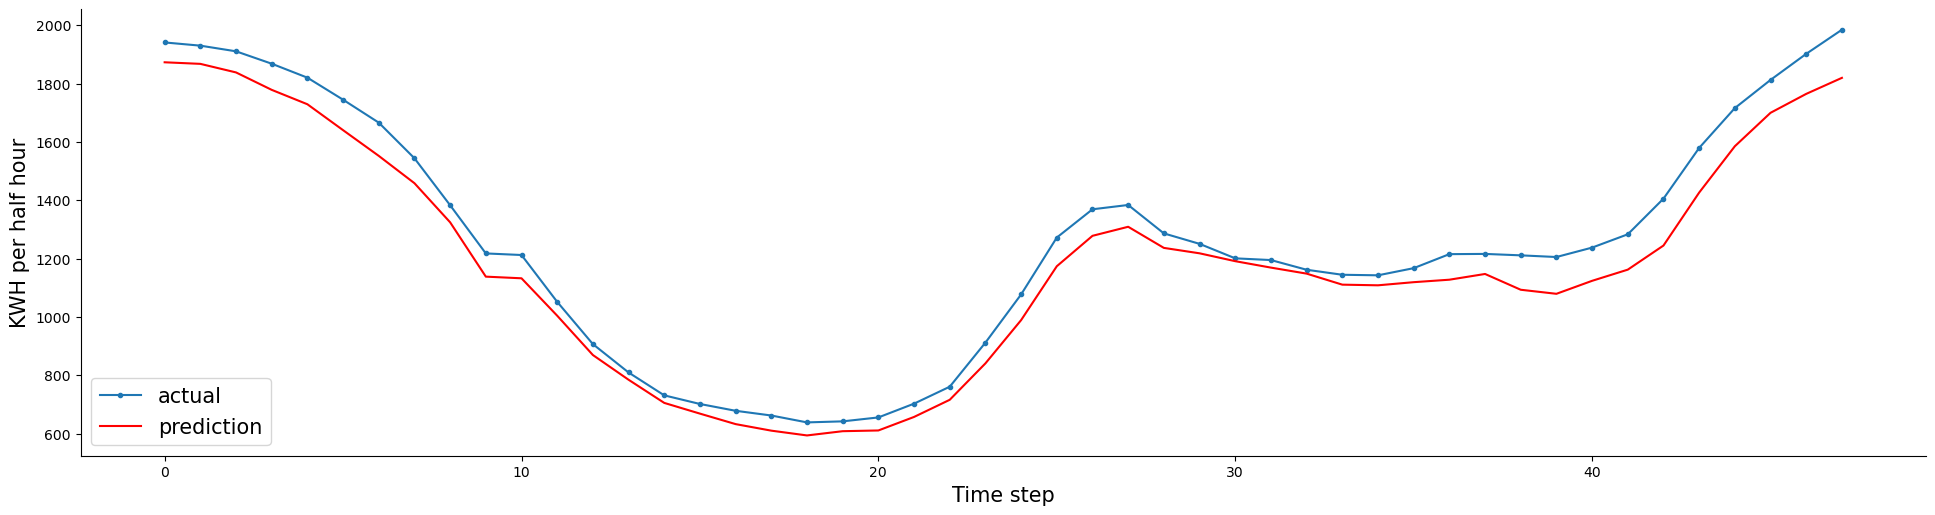

In [97]:
# visualize naive forecast and actuals for first 24 hours of the test dataset
# print(train_size, val_size, test_size)
# print(train_size+val_size)
prediction_plot(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

In [98]:
# standardize the baseline 
# (NaiveForecast - train_mean) / train_std
NaiveForecastNormed = NaiveForecast.transform(lambda x: (x - train_mean) / train_std)
NaiveForecastNormed.describe()

weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  \
count    38887.000000    38887.000000   38887.000000   38887.000000   
mean      1349.947582     1254.857154    1274.325212    1274.469377   
std        771.711161      717.243809     728.325804     728.408175   
min         11.198951       10.597363      10.840604      10.841873   
25%        804.757318      748.146404     759.785372     759.871344   
50%       1315.480669     1222.822915    1241.796018    1241.936504   
75%       1834.503010     1705.212674    1731.639088    1731.834973   
max       3908.027484     3632.387849    3688.590674    3689.007883   

         dailyTrend  dailySeasonal    dailyResid   weeklyTrend  \
count  38887.000000   38887.000000  38887.000000  38887.000000   
mean       0.146062       3.471403      5.260502      0.146760   
std        1.105714       1.984045      3.006419      1.109636   
min       -1.772107       0.029523      0.045028     -1.778214   
25%       -0.635091       2.069737      3.136559     -0.637164   
50%        0.096678       3.382790      5.126226      0.097200   
75%        0.840337       4.717180      7.148225      0.843498   
max        3.811299      10.048145     15.226226      3.824999   

       weeklySeasonal   weeklyResid  AggregateLoad_1dayLag  \
count    38887.000000  38887.000000           38887.000000   
mean         3.405937      5.326744               0.126728   
std          1.946680      3.044478               0.934540   
min          0.028877      0.045246              -1.494492   
25%          2.030667      3.175913              -0.533496   
50%          3.318992      5.190768               0.084989   
75%          4.628252      7.238363               0.713523   
max          9.858820     15.418626               3.224555   

       AggregateLoad_1weekLag  AggregateLoad_halfhourdiff   temperature  \
count            38887.000000                38887.000000  38887.000000   
mean                 0.142421                   14.219262    155.232251   
std                  0.924895                    8.127191     89.696798   
min                 -1.462067                    0.120379     -0.371908   
25%                 -0.510989                    8.477651     91.864215   
50%                  0.101112                   13.856277    151.226126   
75%                  0.723160                   19.322303    211.552637   
max                  3.208276                   41.159396    452.560564   

        temp_daymax  AggregateLoad  
count  38887.000000   38887.000000  
mean     144.990075       0.123737  
std       84.072924       0.936022  
min       -0.857902      -1.500056  
25%       85.595133      -0.537534  
50%      141.235129       0.081931  
75%      197.779245       0.711463  
max      423.676284       3.226478

In [99]:
# calculate error for baseline naive model (Normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

valNaiveMAE:  0.08646842339205185
testNaiveMAE:  0.11402715044672289


In [100]:
# calculate error for baseline naive model (not normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size:train_size+val_size], NaiveForecast[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:], NaiveForecast[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)


Naive Root Mean Squared Error(RMSE): 93.05; Naive Mean Absolute Error(MAE) : 60.61; Naive Mean Absolute Percantage Error(MAPE) : 0.08 
valNaiveMAE:  47.578708576825825
testNaiveMAE:  62.74272558841627


In [101]:
# function for plotting the train and test loss curves
def plot_model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    return

In [102]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size], verbose=0)
multi_test_performance['Baseline'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:], verbose=0)
print(multi_val_performance['Baseline'], multi_test_performance['Baseline'])

[0.016328072175383568, 0.0864684134721756] [0.032646629959344864, 0.11402714252471924]


## Multi Layer Perceptron (MLP) Model

Epoch 1/100
856/856 [==============================] - ETA: 0s - loss: 0.1462 - mean_absolute_error: 0.2521
Epoch 1: val_loss improved from inf to 0.09110, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 7s 7ms/step - loss: 0.1462 - mean_absolute_error: 0.2521 - val_loss: 0.0911 - val_mean_absolute_error: 0.2207
Epoch 2/100
852/856 [============================>.] - ETA: 0s - loss: 0.0807 - mean_absolute_error: 0.1891
Epoch 2: val_loss improved from 0.09110 to 0.07803, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 5s 6ms/step - loss: 0.0807 - mean_absolute_error: 0.1891 - val_loss: 0.0780 - val_mean_absolute_error: 0.2032
Epoch 3/100
843/856 [============================>.] - ETA: 0s - loss: 0.0714 - mean_absolute_error: 0.1779
Epoch 3: val_loss improved from 0.07803 to 0.07161, saving model to /tmp/MLP/checkpoint
856/856 [==============================] - 5s 6ms/step - loss: 0.0713 - mean_absolute_error: 0.1778 - val_loss

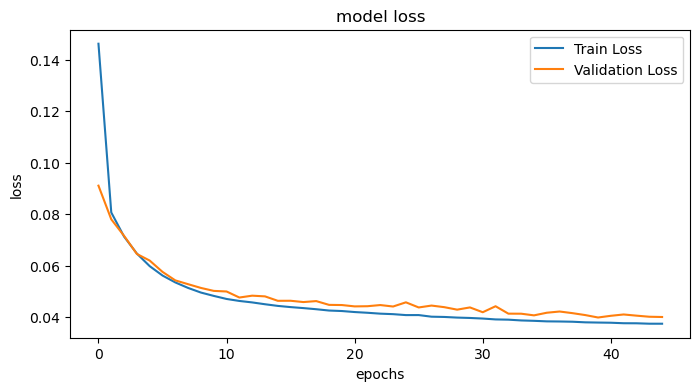

243/243 [==============================] - 1s 3ms/step - loss: 0.0399 - mean_absolute_error: 0.1451


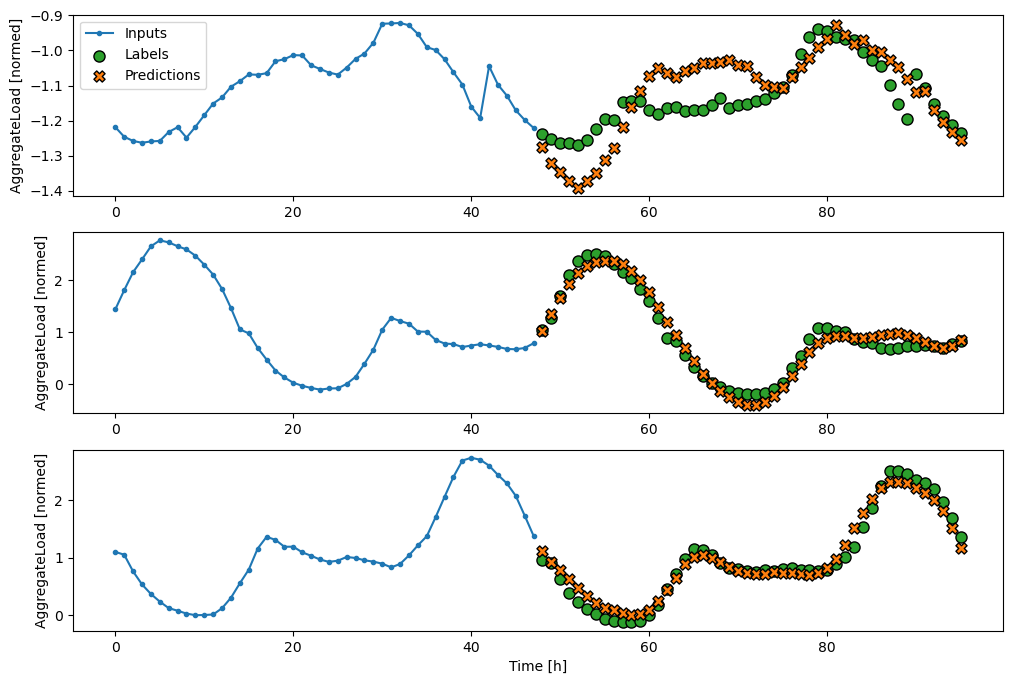

In [103]:
multi_MLP_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="MLP")

history = compile_and_fit(multi_MLP_model, multi_window)
multi_MLP_model.save('multi_MLP_model.keras')
plot_model_loss(history)

# IPython.display.clear_output()
multi_val_performance['MLP'] = multi_MLP_model.evaluate(multi_window.val)
multi_test_performance['MLP'] = multi_MLP_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_MLP_model)

In [104]:
num_out_features

1

## Convolutional Neural Network (CNN) Model



Epoch 1/100
849/856 [============================>.] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.1646
Epoch 1: val_loss improved from inf to 0.02979, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 6s 6ms/step - loss: 0.0672 - mean_absolute_error: 0.1643 - val_loss: 0.0298 - val_mean_absolute_error: 0.1312
Epoch 2/100
854/856 [============================>.] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.1100
Epoch 2: val_loss improved from 0.02979 to 0.02249, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 5s 6ms/step - loss: 0.0241 - mean_absolute_error: 0.1100 - val_loss: 0.0225 - val_mean_absolute_error: 0.1139
Epoch 3/100
846/856 [============================>.] - ETA: 0s - loss: 0.0201 - mean_absolute_error: 0.1007
Epoch 3: val_loss improved from 0.02249 to 0.02086, saving model to /tmp/CNN/checkpoint
856/856 [==============================] - 5s 6ms/step - loss: 0.0201 - mean_absolute_error: 0.1006 - val_loss

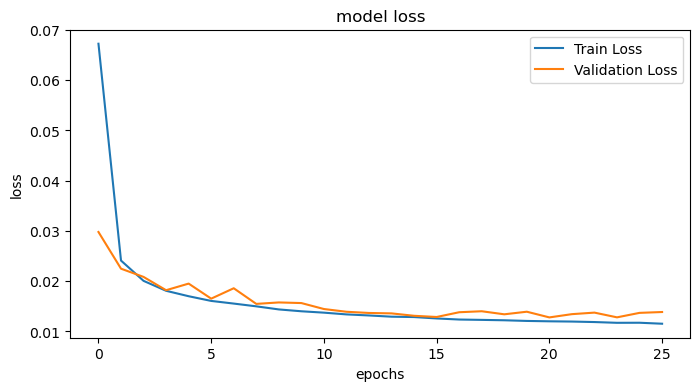

243/243 [==============================] - 1s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0865


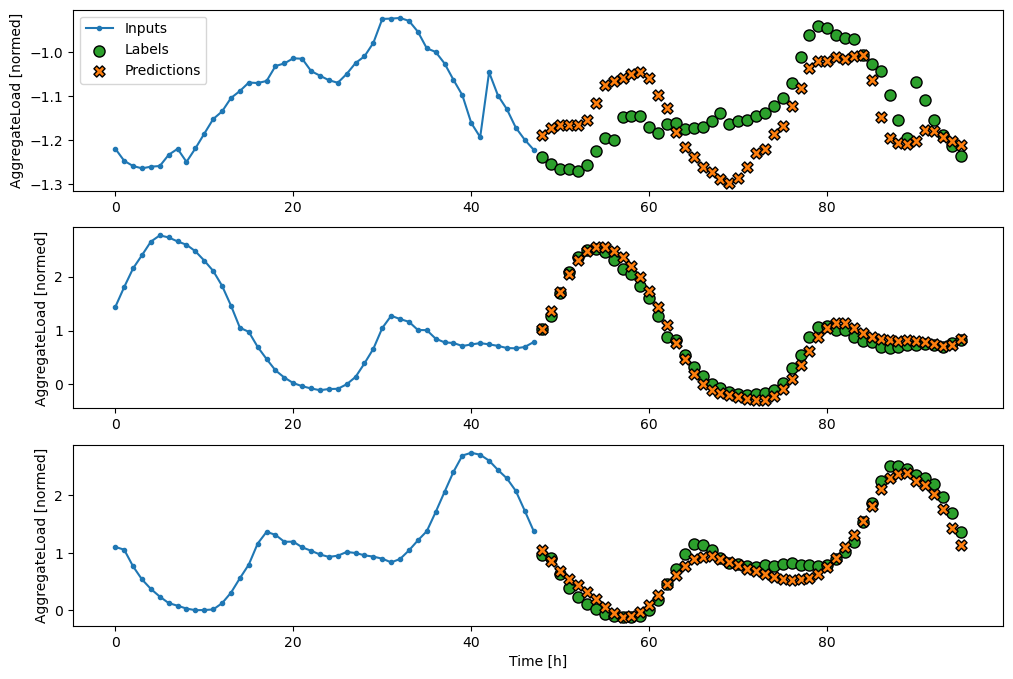

In [105]:
CONV_WIDTH = 10
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    # tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="CNN")

history = compile_and_fit(multi_conv_model, multi_window)
multi_conv_model.save('multi_conv_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


## Recurrent Neural Network (RNN) Model

Epoch 1/100
855/856 [============================>.] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.2083
Epoch 1: val_loss improved from inf to 0.02724, saving model to /tmp/RNN/checkpoint
856/856 [==============================] - 17s 18ms/step - loss: 0.1001 - mean_absolute_error: 0.2083 - val_loss: 0.0272 - val_mean_absolute_error: 0.1290
Epoch 2/100
855/856 [============================>.] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.1059
Epoch 2: val_loss improved from 0.02724 to 0.01874, saving model to /tmp/RNN/checkpoint
856/856 [==============================] - 15s 18ms/step - loss: 0.0207 - mean_absolute_error: 0.1059 - val_loss: 0.0187 - val_mean_absolute_error: 0.1067
Epoch 3/100
854/856 [============================>.] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.0923
Epoch 3: val_loss did not improve from 0.01874
856/856 [==============================] - 13s 16ms/step - loss: 0.0159 - mean_absolute_error: 0.0922 - val_loss: 0.0203 - val_mean_absolute_error:

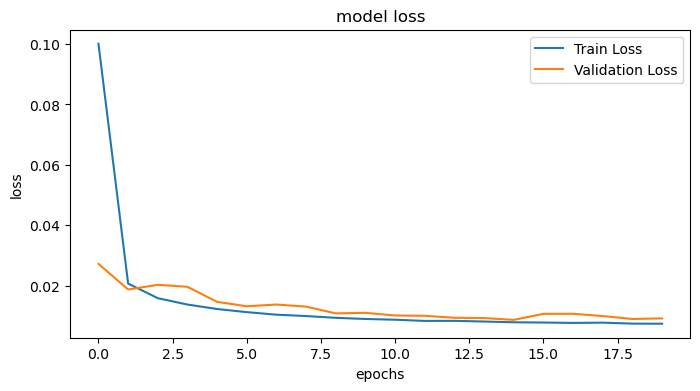

243/243 [==============================] - 2s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0707


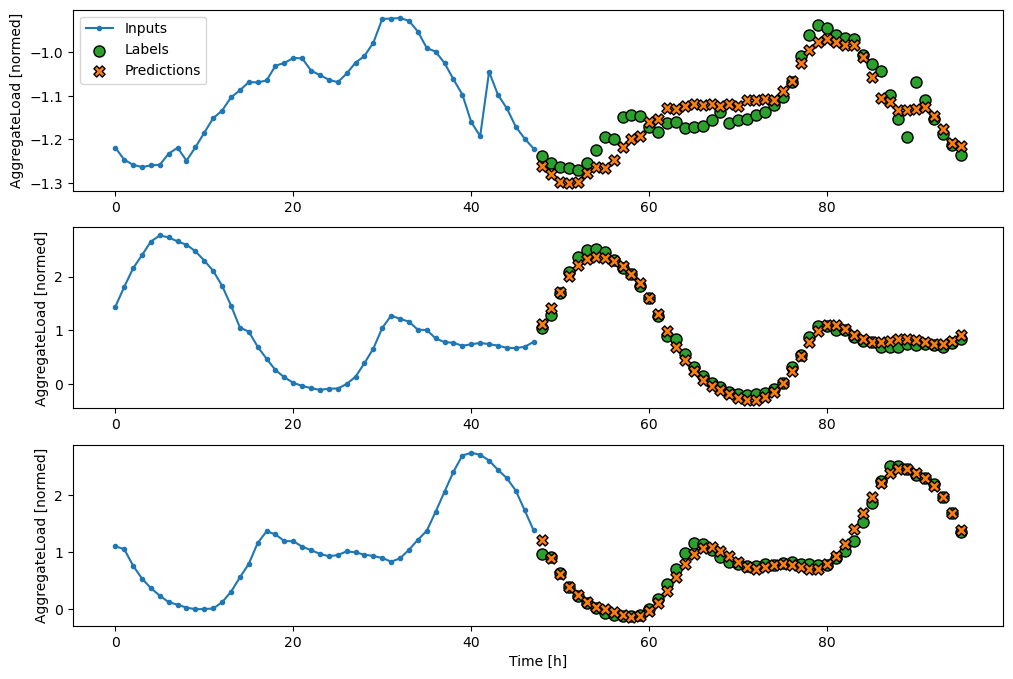

In [106]:
multi_rnn_model = tf.keras.Sequential([
    # tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="RNN")

history = compile_and_fit(multi_rnn_model, multi_window)
plot_model_loss(history)
multi_rnn_model.save('multi_rnn_model.keras')
# IPython.display.clear_output()

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_test_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_rnn_model)

## Long Short Term Memory (LSTM) Model

Epoch 1/100
855/856 [============================>.] - ETA: 0s - loss: 0.0788 - mean_absolute_error: 0.1684
Epoch 1: val_loss improved from inf to 0.01651, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 38s 42ms/step - loss: 0.0788 - mean_absolute_error: 0.1684 - val_loss: 0.0165 - val_mean_absolute_error: 0.0995
Epoch 2/100
855/856 [============================>.] - ETA: 0s - loss: 0.0119 - mean_absolute_error: 0.0779
Epoch 2: val_loss improved from 0.01651 to 0.01262, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 37s 44ms/step - loss: 0.0119 - mean_absolute_error: 0.0778 - val_loss: 0.0126 - val_mean_absolute_error: 0.0859
Epoch 3/100
855/856 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0676
Epoch 3: val_loss improved from 0.01262 to 0.00998, saving model to /tmp/LSTM/checkpoint
856/856 [==============================] - 36s 42ms/step - loss: 0.0091 - mean_absolute_error: 0.0676 -

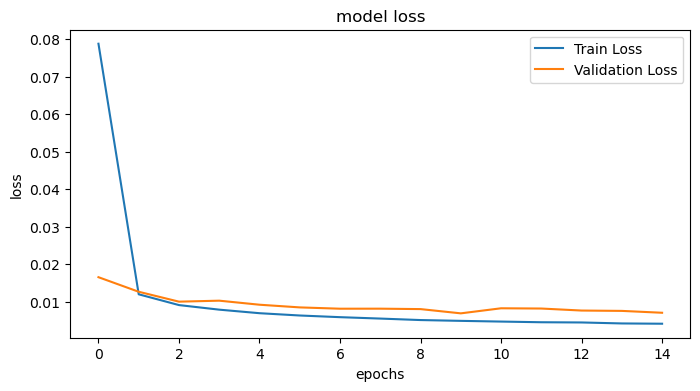

243/243 [==============================] - 3s 13ms/step - loss: 0.0069 - mean_absolute_error: 0.0611


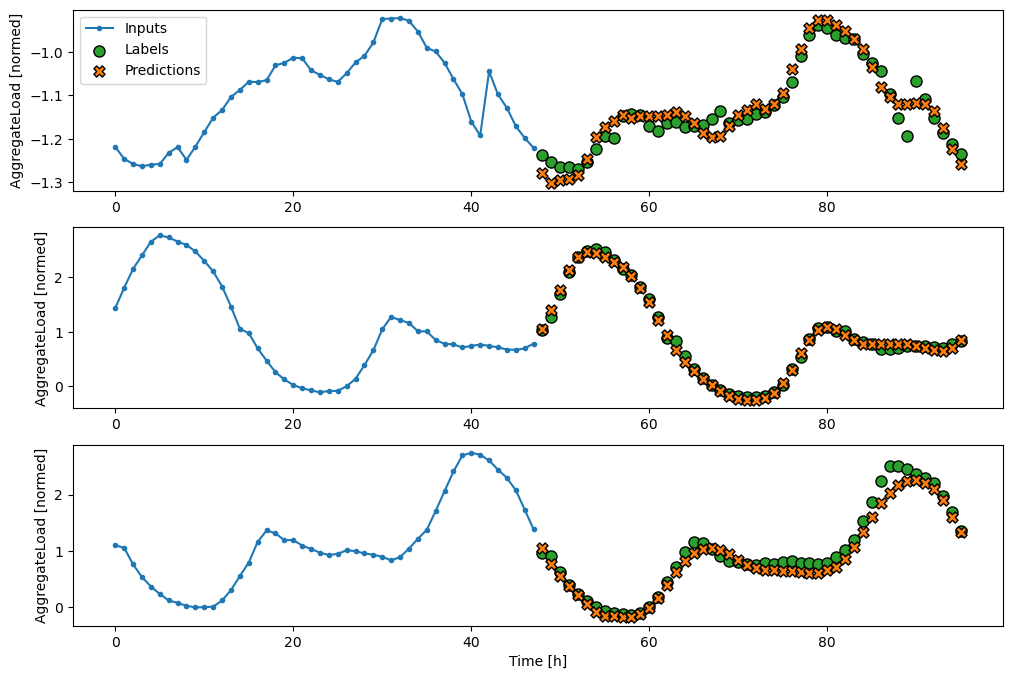

In [107]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="LSTM")

start_time = time.time()
history = compile_and_fit(multi_lstm_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_lstm_model.save('multi_lstm_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


# GRU Model

Epoch 1/100
855/856 [============================>.] - ETA: 0s - loss: 0.0761 - mean_absolute_error: 0.1681
Epoch 1: val_loss improved from inf to 0.01738, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 39s 42ms/step - loss: 0.0761 - mean_absolute_error: 0.1681 - val_loss: 0.0174 - val_mean_absolute_error: 0.1023
Epoch 2/100
855/856 [============================>.] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0823
Epoch 2: val_loss improved from 0.01738 to 0.01233, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 37s 43ms/step - loss: 0.0135 - mean_absolute_error: 0.0823 - val_loss: 0.0123 - val_mean_absolute_error: 0.0843
Epoch 3/100
855/856 [============================>.] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.0713
Epoch 3: val_loss improved from 0.01233 to 0.00978, saving model to /tmp/GRU/checkpoint
856/856 [==============================] - 35s 40ms/step - loss: 0.0101 - mean_absolute_error: 0.0713 - va

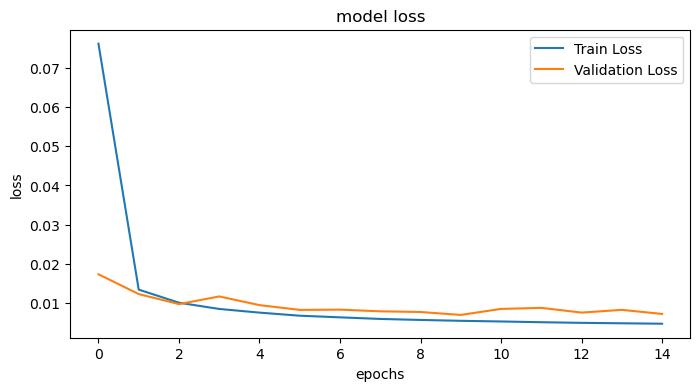

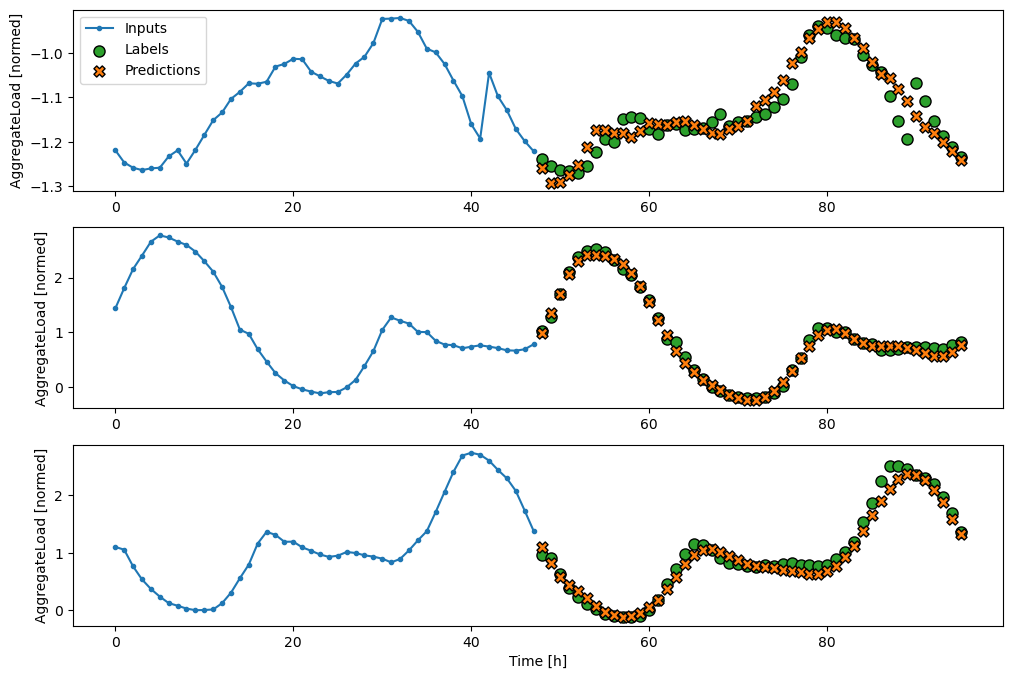

In [108]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    # tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_out_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_out_features])
], name="GRU")

start_time = time.time()
history = compile_and_fit(multi_gru_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_gru_model.save('multi_gru_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val, verbose=0)
multi_test_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

# Model Evaluation and Selection

print('\nValidation Performance:\n', multi_val_performance)
print('\nTest Performance:\n', multi_test_performance)

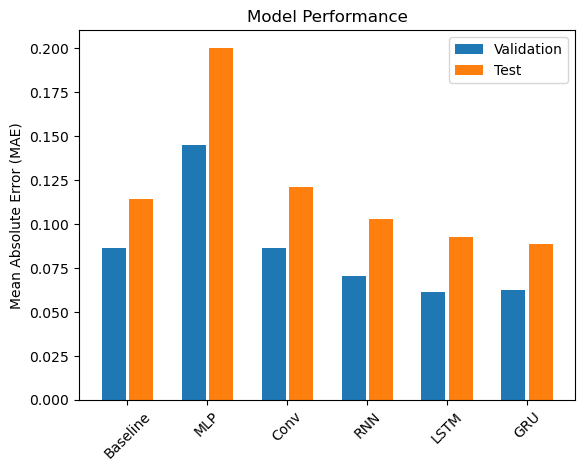

In [109]:
x = np.arange(len(multi_test_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'Mean Absolute Error (MAE)')
_ = plt.legend()
plt.title(f'Model Performance')
plt.savefig('model performance.png', format='png')


In [110]:
CONV_WIDTH = 10 # CNN model would not load without this...
# restore models from file
multi_MLP_model = tf.keras.models.load_model('multi_MLP_model.keras')
multi_conv_model = tf.keras.models.load_model('multi_conv_model.keras')
multi_rnn_model = tf.keras.models.load_model('multi_rnn_model.keras')
multi_lstm_model = tf.keras.models.load_model('multi_lstm_model.keras')
multi_gru_model = tf.keras.models.load_model('multi_gru_model.keras')
model_list = [multi_MLP_model, multi_conv_model, multi_rnn_model, multi_lstm_model, multi_gru_model]


In [111]:
for model in model_list:
    print(model.name)

MLP
CNN
RNN
LSTM
GRU


In [112]:
# store the evaluation results for all models
import pickle
with open('model eval results.pkl', 'wb') as f:
    pickle.dump(multi_val_performance, f)

with open('model test results.pkl', 'wb') as f:
    pickle.dump(multi_test_performance, f)

In [113]:
# load the evaluation results for all models
with open('model eval results.pkl', 'rb') as f:
    multi_val_performance = pickle.load(f)

with open('model test results.pkl', 'rb') as f:
    multi_test_performance = pickle.load(f)

print(multi_val_performance)
print(multi_test_performance)

{'Baseline': [0.016328072175383568, 0.0864684134721756], 'MLP': [0.039901118725538254, 0.14508682489395142], 'Conv': [0.012800930067896843, 0.08652207255363464], 'RNN': [0.008696194738149643, 0.07069828361272812], 'LSTM': [0.00686339195817709, 0.0611039437353611], 'GRU': [0.007017396856099367, 0.06232822313904762]}
{'Baseline': [0.032646629959344864, 0.11402714252471924], 'MLP': [0.0742543563246727, 0.20036253333091736], 'Conv': [0.025845510885119438, 0.1212867945432663], 'RNN': [0.019438346847891808, 0.1027536392211914], 'LSTM': [0.015761587768793106, 0.0924261063337326], 'GRU': [0.014521258883178234, 0.08868680149316788]}


## Feature Evaluation (methods that require models already built)

In [114]:
# function to create time series dataset for feature permutation
def generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=None,
                                cols_to_shuffle=None,
                              train_df=train_data, val_df=val_data, test_df=test_data):
    
    train = train_df.copy()
    val = val_df.copy()
    test = test_df.copy()
    
    # randomly shuffle shuffle the specified columns
    for col in cols_to_shuffle:
        # print('\nShuffling: ', col)
        # print('\nTrain Before:\n', train[col])
        train[col] = train[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        # print('\nShuffle:\n', train[col].sample(frac=1, replace=False, random_state=randomState))
        # print('\nAfter:\n', train[col])
        # print('\nVal Before:\n', val[col])
        val[col] = val[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        # print('\nShuffle:\n', val[col].sample(frac=1, replace=False, random_state=randomState))
        # print('\nAfter:\n', val[col])
        # print('\nTest Before:\n', test[col])
        test[col] = test[col].sample(frac=1, replace=False, random_state=randomState, ignore_index=True)
        # print('\nShuffle:\n', test[col].sample(frac=1, replace=False, random_state=randomState))
        # print('\nAfter:\n', test[col])
    
    """
    print('train NaNs: ', train.isnull().sum().sum())
    print('val NaNs: ', val.isnull().sum().sum())
    print('val NaNs:\n', val[val.isna().any(axis=1)])
    print('test NaNs: ', test.isnull().sum().sum())
    print('test NaNs:\n', test[test.isna().any(axis=1)])
    """

    feat_perm_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                              train_df=train, val_df=val, test_df=test,)
    
    return feat_perm_window


In [115]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Define a function to calculate the permutation importance of a feature group for a given model
def calculate_permutation_importance_group(model, feature_group, baseline_val_perf, baseline_test_perf):
    """Calculates the permutation importance of a feature group for a given model.

    Args:
        model: The model to calculate the permutation importance for.
        feature_group: A list of the features in the feature group.
        baseline_val_perf: baseline performance (in MAE) of the model using all features for the validation set
        baseline_test_perf: baseline performance (in MAE) of the model using all features for the test set
        
    Returns:
        The permutation importance of the feature group for the given model.
    """

    # Shuffle the values of the features in the feature group
    feat_perm_window = generateFeatPermWindow(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=label_columns,
                                cols_to_shuffle=feature_group,
                              train_df=train_data, val_df=val_data, test_df=test_data)
    
    # model.fit(X_shuffled, y)
    val_perf_shuffle = model.evaluate(feat_perm_window.val, verbose=1)[1] # MAE

    # Calculate the permutation importance
    # importance = np.mean(y - y_pred)
    importance = val_perf_shuffle - baseline_val_perf
    
    print('\nModel: ', model.name, feature_group, 'importance: ', importance)

    return importance

In [116]:
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    permutation_importances_values = list(importances.values())

    # Create a bar chart of the permutation importances
    plt.bar(importances.keys(), permutation_importances_values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(importances.keys())
    plt.tick_params(rotation=45)
    plt.show()

## Permutation Feature Importance

In [117]:
# Calculate the permutation feature importance for each model and visualize the results
# cyclically encoded features need to be grouped together for the purposes of feature permutation importance
feature_groups = {
    'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'],
    'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'],
#    'minuteOfDay': ['minuteOfDay_sin', 'minuteOfDay_cos'],
}

grouped_features = [value for key, value in feature_groups.items() for value in value]
print('grouped_features: ', grouped_features, '\n')

# add individual features as feature groups of one
for feature in val_data.columns:
    if feature not in grouped_features:
        feature_groups[feature] = [feature]

print('feature_groups: ', feature_groups)

permutation_importances_groups = {}
for model in model_list:
    # calculate baseline model performance with all features
    print('\ncalculate baseline model performance with all features.\n', model.name)
    val_perf = model.evaluate(multi_window.val, verbose=1)[1] # MAE
    test_perf = model.evaluate(multi_window.test, verbose=1)[1] # MAE

    for feature_group_name, feature_group in feature_groups.items():
        permutation_importance = calculate_permutation_importance_group(model, feature_group, val_perf, test_perf)
        if model.name not in permutation_importances_groups:
            permutation_importances_groups[model.name] = {}
        permutation_importances_groups[model.name][feature_group_name] = permutation_importance


grouped_features:  ['weekOfYear_sin', 'weekOfYear_cos', 'dayOfWeek_sin', 'dayOfWeek_cos'] 

feature_groups:  {'weekOfYear': ['weekOfYear_sin', 'weekOfYear_cos'], 'dayOfWeek': ['dayOfWeek_sin', 'dayOfWeek_cos'], 'dailyTrend': ['dailyTrend'], 'dailySeasonal': ['dailySeasonal'], 'dailyResid': ['dailyResid'], 'weeklyTrend': ['weeklyTrend'], 'weeklySeasonal': ['weeklySeasonal'], 'weeklyResid': ['weeklyResid'], 'AggregateLoad_1dayLag': ['AggregateLoad_1dayLag'], 'AggregateLoad_1weekLag': ['AggregateLoad_1weekLag'], 'AggregateLoad_halfhourdiff': ['AggregateLoad_halfhourdiff'], 'temperature': ['temperature'], 'temp_daymax': ['temp_daymax'], 'AggregateLoad': ['AggregateLoad']}

calculate baseline model performance with all features.
 MLP
243/243 [==============================] - 1s 3ms/step - loss: 0.0510 - mean_absolute_error: 0.1656

Model:  MLP ['weekOfYear_sin', 'weekOfYear_cos'] importance:  0.020468026399612427
243/243 [==============================] - 1s 3ms/step - loss: 0.0801 - mean_

In [118]:
permutation_importances_groups

{'MLP': {'weekOfYear': 0.020468026399612427,
  'dayOfWeek': 0.047376349568367004,
  'dailyTrend': 0.03532436490058899,
  'dailySeasonal': 0.6132853031158447,
  'dailyResid': 0.07540649175643921,
  'weeklyTrend': 0.03853714466094971,
  'weeklySeasonal': 0.44033563137054443,
  'weeklyResid': 0.046755045652389526,
  'AggregateLoad_1dayLag': 0.058090075850486755,
  'AggregateLoad_1weekLag': 0.012084826827049255,
  'AggregateLoad_halfhourdiff': 0.14494681358337402,
  'temperature': 0.11373147368431091,
  'temp_daymax': 0.11250168085098267,
  'AggregateLoad': 0.5043542981147766},
 'CNN': {'weekOfYear': 0.018702946603298187,
  'dayOfWeek': 0.04747714102268219,
  'dailyTrend': 0.03473406285047531,
  'dailySeasonal': 0.522637277841568,
  'dailyResid': 0.14955076575279236,
  'weeklyTrend': 0.024567827582359314,
  'weeklySeasonal': 0.2144327461719513,
  'weeklyResid': 0.07714308798313141,
  'AggregateLoad_1dayLag': 0.04372647404670715,
  'AggregateLoad_1weekLag': 0.027466386556625366,
  'Aggregat

In [119]:
from operator import itemgetter, attrgetter
# Define a function to visualize the permutation importances for a given feature using a stacked bar chart
def visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances):
    """Visualizes the permutation importances for a given feature using a stacked bar chart created with the plt.stackplot() function.

    Args:
        feature: The feature to visualize the permutation importances for.
        permutation_importances: A dictionary mapping the model names to the permutation importances for the given feature.
    """

    # Get the permutation importances for each feature in a list
    importances = sorted(permutation_importances.items(), key=itemgetter(1), reverse=True)
    print(importances)
    df = pd.DataFrame(importances, columns=['label', 'value'])
    labels = df['label'].tolist()
    values = df['value'].tolist()


    # Create a stacked bar chart of the permutation importances
    plt.bar(labels, values)
    plt.xlabel('Feature')
    plt.ylabel('Permutation Importance')
    plt.title('Permutation Importances for Model: {}'.format(model))
    plt.legend(labels)
    plt.tick_params(rotation=90)
    plt.show()

[('dailySeasonal', 0.6132853031158447), ('AggregateLoad', 0.5043542981147766), ('weeklySeasonal', 0.44033563137054443), ('AggregateLoad_halfhourdiff', 0.14494681358337402), ('temperature', 0.11373147368431091), ('temp_daymax', 0.11250168085098267), ('dailyResid', 0.07540649175643921), ('AggregateLoad_1dayLag', 0.058090075850486755), ('dayOfWeek', 0.047376349568367004), ('weeklyResid', 0.046755045652389526), ('weeklyTrend', 0.03853714466094971), ('dailyTrend', 0.03532436490058899), ('weekOfYear', 0.020468026399612427), ('AggregateLoad_1weekLag', 0.012084826827049255)]


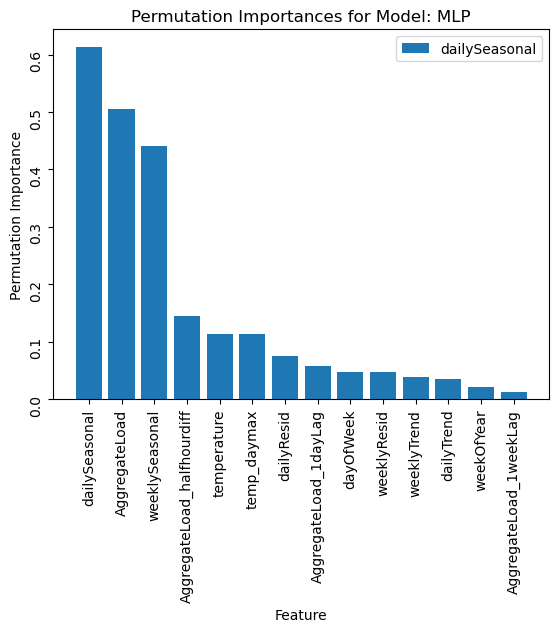

[('AggregateLoad', 0.5621266663074493), ('dailySeasonal', 0.522637277841568), ('weeklySeasonal', 0.2144327461719513), ('AggregateLoad_halfhourdiff', 0.2063412070274353), ('dailyResid', 0.14955076575279236), ('weeklyResid', 0.07714308798313141), ('dayOfWeek', 0.04747714102268219), ('AggregateLoad_1dayLag', 0.04372647404670715), ('dailyTrend', 0.03473406285047531), ('temperature', 0.02758493274450302), ('AggregateLoad_1weekLag', 0.027466386556625366), ('weeklyTrend', 0.024567827582359314), ('temp_daymax', 0.024104498326778412), ('weekOfYear', 0.018702946603298187)]


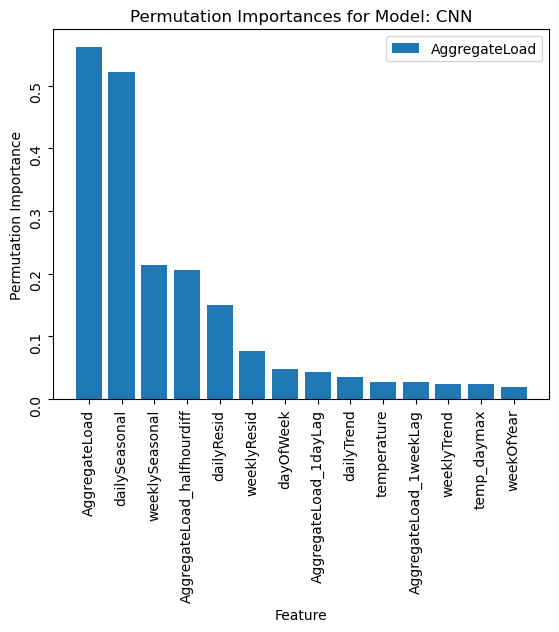

[('AggregateLoad', 0.6048169508576393), ('dailySeasonal', 0.3181302025914192), ('weeklySeasonal', 0.1346634104847908), ('AggregateLoad_halfhourdiff', 0.09171020239591599), ('weeklyTrend', 0.06983184069395065), ('dailyTrend', 0.06951919943094254), ('dailyResid', 0.06460084766149521), ('weekOfYear', 0.04345747083425522), ('dayOfWeek', 0.03188522160053253), ('temp_daymax', 0.03129903972148895), ('weeklyResid', 0.027734190225601196), ('AggregateLoad_1weekLag', 0.018545687198638916), ('AggregateLoad_1dayLag', 0.018102459609508514), ('temperature', 0.017389804124832153)]


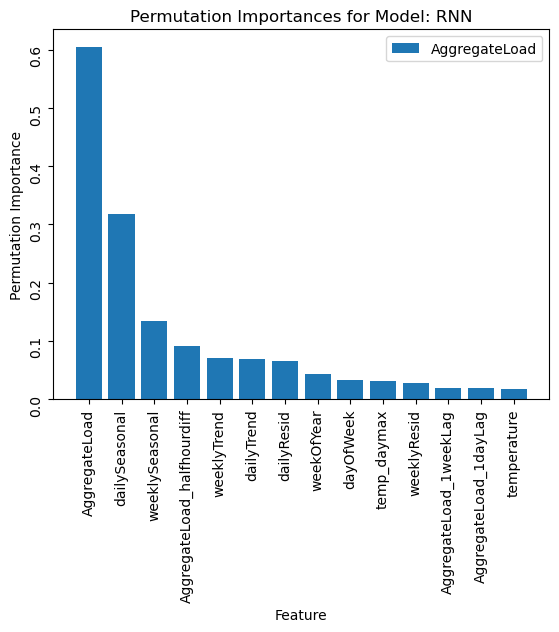

[('AggregateLoad', 0.5962763391435146), ('dailySeasonal', 0.11035970970988274), ('AggregateLoad_halfhourdiff', 0.08475012704730034), ('weeklySeasonal', 0.07075734063982964), ('dailyResid', 0.04344091936945915), ('dailyTrend', 0.024730805307626724), ('weekOfYear', 0.023221496492624283), ('weeklyResid', 0.022937852889299393), ('dayOfWeek', 0.022682171314954758), ('weeklyTrend', 0.017115306109189987), ('temp_daymax', 0.011955257505178452), ('AggregateLoad_1dayLag', 0.008783053606748581), ('AggregateLoad_1weekLag', 0.0076499320566654205), ('temperature', 0.006005521863698959)]


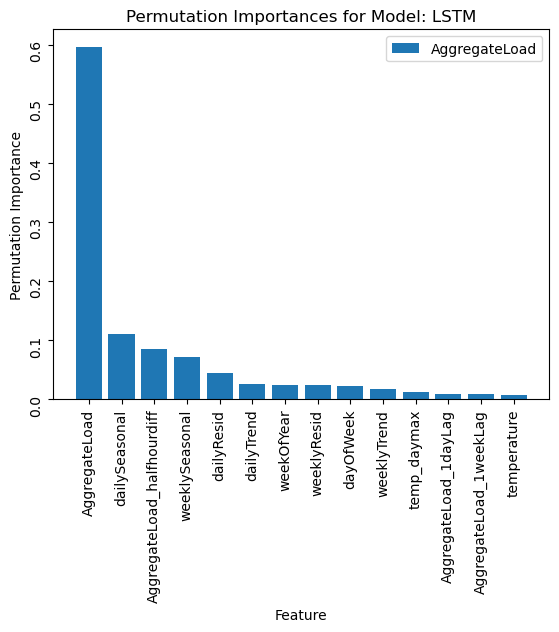

[('AggregateLoad', 0.6025395952165127), ('dailySeasonal', 0.189665075391531), ('AggregateLoad_halfhourdiff', 0.1285574696958065), ('weeklySeasonal', 0.07830555364489555), ('dailyResid', 0.05136896297335625), ('dailyTrend', 0.03589269891381264), ('dayOfWeek', 0.025405962020158768), ('weekOfYear', 0.0248262919485569), ('weeklyResid', 0.022838521748781204), ('weeklyTrend', 0.017248395830392838), ('temp_daymax', 0.013221945613622665), ('AggregateLoad_1dayLag', 0.008858468383550644), ('temperature', 0.005409475415945053), ('AggregateLoad_1weekLag', 0.0036206282675266266)]


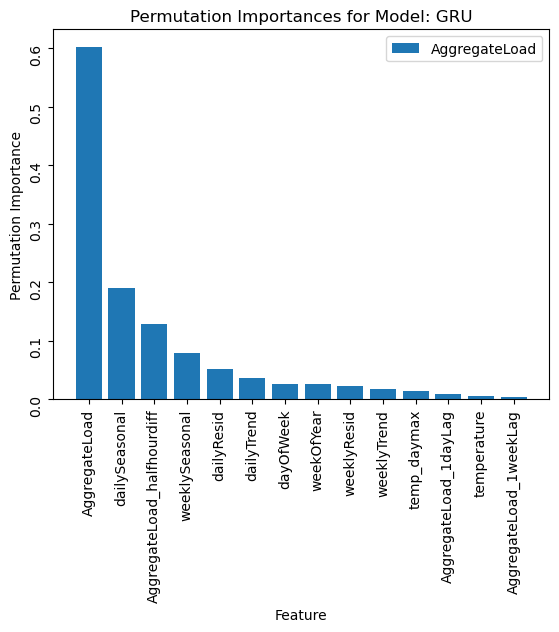

In [120]:
# Visualize the permutation importances for each feature using a stacked bar chart
for model, permutation_importances in permutation_importances_groups.items():
    visualize_permutation_importances_stacked_bar_stackplot(model, permutation_importances)

# Winning Model Results

## Single Day results: Benchmark, GRU model and actuals

In [121]:
# build a single record dataset from start of the test dataset
# print(mergeDataNormed)
# print(train_size+test_size-IN_STEPS)
# print(mergeDataNormed.iloc[train_size+test_size-IN_STEPS:train_size+test_size])

oneDay_ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data[:IN_STEPS],
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(oneDay_ds)

1/1 [==============================] - 1s 547ms/step


In [122]:
# print(testYhatNormed) # prediction for all input columns
print(testYhatNormed[0,:,-1]) # prediction for target column, aggregate load

[ 2.1734624   2.182756    2.1285226   2.058014    1.9392375   1.7419956
  1.4727844   1.1846431   0.8946627   0.63200027  0.41740546  0.23673391
  0.07883342 -0.06243294 -0.1625604  -0.27289802 -0.32095942 -0.35210478
 -0.36814535 -0.39116892 -0.365596   -0.3013309  -0.13901457  0.11114898
  0.39134187  0.6448003   0.786879    0.83036476  0.78130287  0.70912594
  0.636817    0.60068214  0.58389306  0.57974684  0.56906545  0.53772956
  0.51981074  0.50466853  0.5188334   0.53867143  0.5896439   0.69713235
  0.86936533  1.1024972   1.3938769   1.6858419   1.9294591   2.0653489 ]


In [123]:
# Invert standardization
testYhat = (np.array(testYhatNormed) * np.array(train_std)) + np.array(train_mean)

# print(testYhat)
print(testYhat[0,:,-1])

[2028.99433691 2034.10805803 2004.26651733 1965.46953645 1900.11354368
 1791.58242188 1643.45065948 1484.90274044 1325.34280182 1180.81445489
 1062.73500365  963.32161839  876.43785839  798.70692986  743.61242064
  682.89983883  656.45435404  639.31681248  630.4905928   617.82201451
  631.89335682  667.2548269   756.56836697  894.21929687 1048.39367575
 1187.85759558 1266.0355094  1289.96327695 1262.96727673 1223.2523711
 1183.46481993 1163.58185099 1154.34376555 1152.06233489 1146.1849665
 1128.94258906 1119.08286772 1110.75096567 1118.54509395 1129.46084856
 1157.50812647 1216.65297494 1311.42309682 1439.70245716 1600.03230729
 1760.68422478 1894.73305109 1969.50554543]


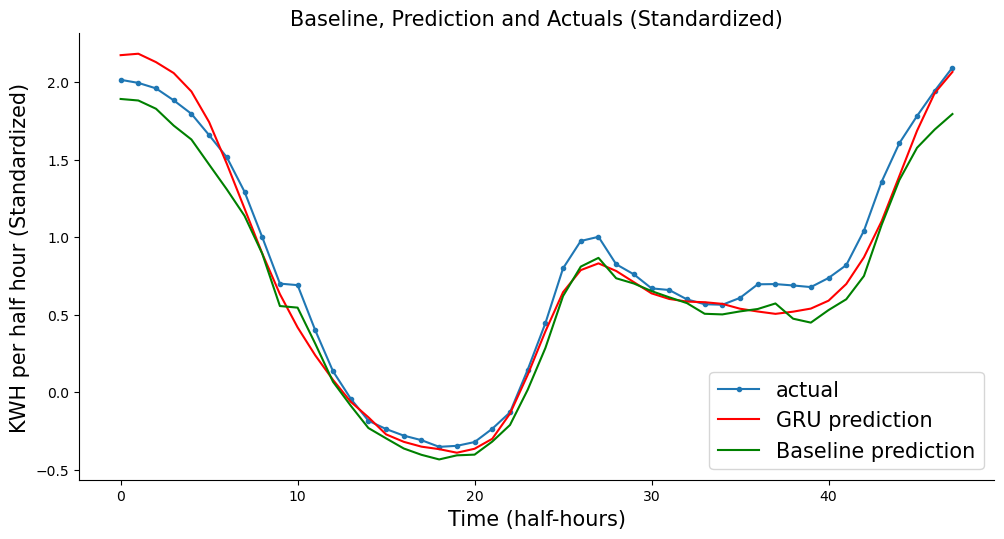

<Figure size 640x480 with 0 Axes>

In [124]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="actual")
plt.plot(len_prediction, testYhatNormed[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecastNormed[train_size+val_size:train_size+val_size+OUT_STEPS].AggregateLoad, 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('KWH per half hour (Standardized)', size=15)
plt.xlabel('Time (half-hours)', size=15)
plt.legend(fontsize=15)
plt.title('Baseline, Prediction and Actuals (Standardized)', size=15)
plt.show();
plt.savefig('Baseline, Prediction and Actuals (Standardized).png', format='png')

In [125]:
# calculate error for baseline naive model (Normed) first 24 hours of test set
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for baseline naive model on validation set
valBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size:train_size+OUT_STEPS])

# calculate error for baseline naive model on test set
testBaselineMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS])

print('valBaselineMAE: ', valBaselineMAE)
print('testBaselineMAE: ', testBaselineMAE)

valBaselineMAE:  0.049099289077088826
testBaselineMAE:  0.13447364498982925


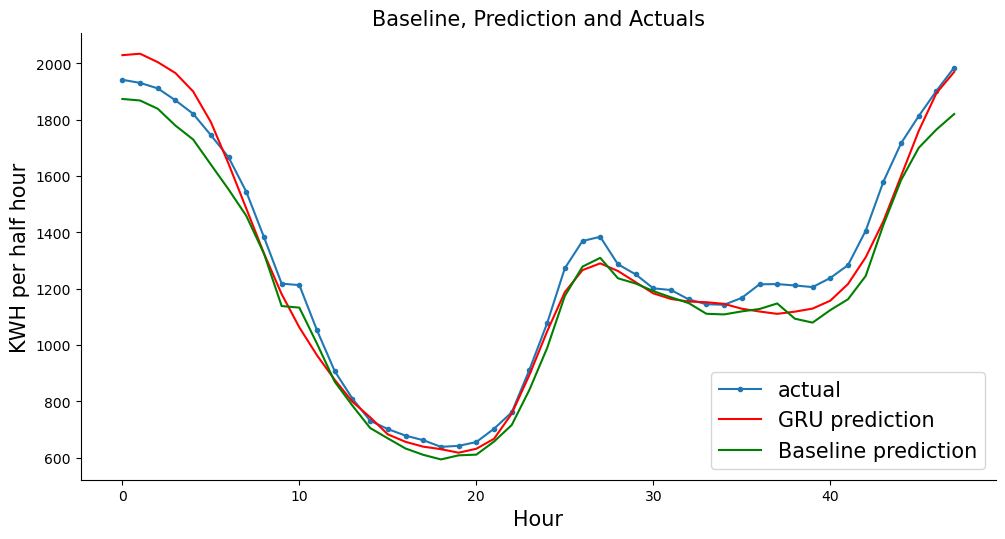

<Figure size 640x480 with 0 Axes>

In [126]:
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="actual")
plt.plot(len_prediction, testYhat[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 'g', label="Baseline prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('KWH per half hour', size=15)
plt.xlabel('Hour', size=15)
plt.legend(fontsize=15)
plt.title('Baseline, Prediction and Actuals', size=15)
plt.show()
plt.savefig('Baseline, Prediction and Actuals.png', format='png')

## Aggregate results for Test period: Benchmark, GRU model and actuals

In [127]:
# build dataset for the test dataset

ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data,
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(ds)

122/122 [==============================] - 1s 11ms/step


In [128]:
print(testYhatNormed.shape)
print(testYhatNormed)

(3876, 48, 1)
[[[2.1734626 ]
  [2.182756  ]
  [2.1285224 ]
  ...
  [1.685842  ]
  [1.9294593 ]
  [2.0653489 ]]

 [[2.1453314 ]
  [2.1010566 ]
  [2.0146031 ]
  ...
  [1.9266726 ]
  [2.073537  ]
  [2.114122  ]]

 [[2.1020417 ]
  [2.0485454 ]
  [1.9312372 ]
  ...
  [2.040578  ]
  [2.0892289 ]
  [2.083009  ]]

 ...

 [[0.29737574]
  [0.2923656 ]
  [0.3002025 ]
  ...
  [0.30003932]
  [0.22955015]
  [0.20896426]]

 [[0.24373645]
  [0.24327648]
  [0.2553436 ]
  ...
  [0.23104258]
  [0.18209346]
  [0.16179682]]

 [[0.23915416]
  [0.22874361]
  [0.23101294]
  ...
  [0.20021404]
  [0.17776147]
  [0.16798839]]]


In [129]:
# Invert standardization
testYhat = testYhatNormed * train_std.AggregateLoad + train_mean.AggregateLoad

print(testYhat.shape)
print(testYhat)

(3876, 48, 1)
[[[2028.9944 ]
  [2034.1079 ]
  [2004.2664 ]
  ...
  [1760.6842 ]
  [1894.7332 ]
  [1969.5054 ]]

 [[2013.5154 ]
  [1989.1533 ]
  [1941.583  ]
  ...
  [1893.1997 ]
  [1974.011  ]
  [1996.3425 ]]

 [[1989.6956 ]
  [1960.2595 ]
  [1895.7114 ]
  ...
  [1955.8755 ]
  [1982.6453 ]
  [1979.2229 ]]

 ...

 [[ 996.6894 ]
  [ 993.9326 ]
  [ 998.24475]
  ...
  [ 998.155  ]
  [ 959.3688 ]
  [ 948.0415 ]]

 [[ 967.1747 ]
  [ 966.92163]
  [ 973.56146]
  ...
  [ 960.18994]
  [ 933.25604]
  [ 922.08795]]

 [[ 964.6533 ]
  [ 958.925  ]
  [ 960.17365]
  ...
  [ 943.22675]
  [ 930.8724 ]
  [ 925.4948 ]]]


# Estimate financial impact of improved forecast

## Load pricing data

Load day forward and real time wholesale electricity pricing data to help us estimate financial benefit of the best model.

In [130]:
prices = pd.read_csv('/kaggle/input/california-iso/CLAP_WISTRA-APND.csv', parse_dates=['INTERVAL_START_GMT','INTERVAL_START_GMT','OPR_DATE'])
prices

INTERVAL_START_GMT           INTERVAL_END_GMT   OPR_DATE  \
0  2022-09-05 07:00:00+00:00  2022-09-05T08:00:00-00:00 2022-09-05   
1  2022-09-05 08:00:00+00:00  2022-09-05T09:00:00-00:00 2022-09-05   
2  2022-09-05 09:00:00+00:00  2022-09-05T10:00:00-00:00 2022-09-05   
3  2022-09-05 10:00:00+00:00  2022-09-05T11:00:00-00:00 2022-09-05   
4  2022-09-05 11:00:00+00:00  2022-09-05T12:00:00-00:00 2022-09-05   
5  2022-09-05 12:00:00+00:00  2022-09-05T13:00:00-00:00 2022-09-05   
6  2022-09-05 13:00:00+00:00  2022-09-05T14:00:00-00:00 2022-09-05   
7  2022-09-05 14:00:00+00:00  2022-09-05T15:00:00-00:00 2022-09-05   
8  2022-09-05 15:00:00+00:00  2022-09-05T16:00:00-00:00 2022-09-05   
9  2022-09-05 16:00:00+00:00  2022-09-05T17:00:00-00:00 2022-09-05   
10 2022-09-05 17:00:00+00:00  2022-09-05T18:00:00-00:00 2022-09-05   
11 2022-09-05 18:00:00+00:00  2022-09-05T19:00:00-00:00 2022-09-05   
12 2022-09-05 19:00:00+00:00  2022-09-05T20:00:00-00:00 2022-09-05   
13 2022-09-05 20:00:00+00:00  2022-09-05T21:00:00-00:00 2022-09-05   
14 2022-09-05 21:00:00+00:00  2022-09-05T22:00:00-00:00 2022-09-05   
15 2022-09-05 22:00:00+00:00  2022-09-05T23:00:00-00:00 2022-09-05   
16 2022-09-05 23:00:00+00:00  2022-09-06T00:00:00-00:00 2022-09-05   
17 2022-09-06 00:00:00+00:00  2022-09-06T01:00:00-00:00 2022-09-05   
18 2022-09-06 01:00:00+00:00  2022-09-06T02:00:00-00:00 2022-09-05   
19 2022-09-06 02:00:00+00:00  2022-09-06T03:00:00-00:00 2022-09-05   
20 2022-09-06 03:00:00+00:00  2022-09-06T04:00:00-00:00 2022-09-05   
21 2022-09-06 04:00:00+00:00  2022-09-06T05:00:00-00:00 2022-09-05   
22 2022-09-06 05:00:00+00:00  2022-09-06T06:00:00-00:00 2022-09-05   
23 2022-09-06 06:00:00+00:00  2022-09-06T07:00:00-00:00 2022-09-05   

    INTERVAL_NUM     RESOURCE_NAME MKT_TYPE DATA_ITEM   Real Time  Day Ahead  \
0              1  CLAP_WISTRA-APND      RTM   LMP_PRC    98.62019  130.29068   
1              2  CLAP_WISTRA-APND      RTM   LMP_PRC    92.28835  111.39344   
2              3  CLAP_WISTRA-APND      RTM   LMP_PRC    93.79471  110.43878   
3              4  CLAP_WISTRA-APND      RTM   LMP_PRC    86.68312  109.91987   
4              5  CLAP_WISTRA-APND      RTM   LMP_PRC    84.92511  106.57047   
5              6  CLAP_WISTRA-APND      RTM   LMP_PRC    85.59492  106.73770   
6              7  CLAP_WISTRA-APND      RTM   LMP_PRC    81.79844  101.55546   
7              8  CLAP_WISTRA-APND      RTM   LMP_PRC    60.17546   95.17314   
8              9  CLAP_WISTRA-APND      RTM   LMP_PRC    35.14356   95.72490   
9             10  CLAP_WISTRA-APND      RTM   LMP_PRC    54.47789   95.59762   
10            11  CLAP_WISTRA-APND      RTM   LMP_PRC    80.87896   95.68329   
11            12  CLAP_WISTRA-APND      RTM   LMP_PRC    90.18439  112.84709   
12            13  CLAP_WISTRA-APND      RTM   LMP_PRC    92.68070  139.25500   
13            14  CLAP_WISTRA-APND      RTM   LMP_PRC   109.00747  150.03902   
14            15  CLAP_WISTRA-APND      RTM   LMP_PRC   114.68054  152.41206   
15            16  CLAP_WISTRA-APND      RTM   LMP_PRC   148.90530  186.63844   
16            17  CLAP_WISTRA-APND      RTM   LMP_PRC   307.45448  235.81935   
17            18  CLAP_WISTRA-APND      RTM   LMP_PRC   832.60104  380.78006   
18            19  CLAP_WISTRA-APND      RTM   LMP_PRC  1797.80330  860.15280   
19            20  CLAP_WISTRA-APND      RTM   LMP_PRC  1967.08950  866.53100   
20            21  CLAP_WISTRA-APND      RTM   LMP_PRC   985.43381  364.56143   
21            22  CLAP_WISTRA-APND      RTM   LMP_PRC   679.87373  203.40000   
22            23  CLAP_WISTRA-APND      RTM   LMP_PRC   165.93040  168.18666   
23            24  CLAP_WISTRA-APND      RTM   LMP_PRC   143.69764  150.23670   

    GROUP  
0     371  
1     371  
2     371  
3     371  
4     371  
5     371  
6     371  
7     371  
8     371  
9     371  
10    371  
11    371  
12    371  
13    371  
14    371  
15    371  
16    371  
17    371  
18    371  
19    371  
20    

## Visualize pricing curve

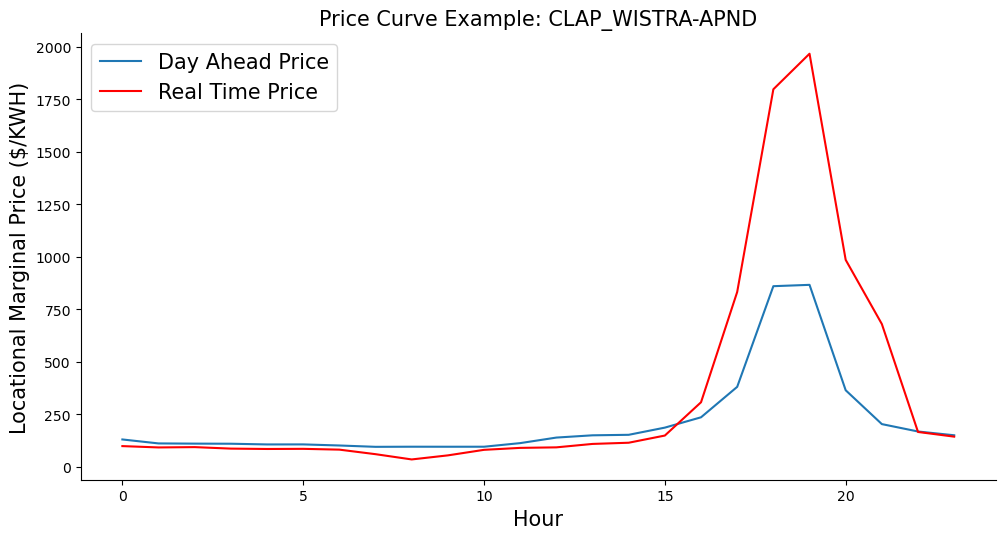

<Figure size 640x480 with 0 Axes>

In [131]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(prices['OPR_DATE']))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, prices['Day Ahead'], label="Day Ahead Price")
plt.plot(len_prediction, prices['Real Time'], 'r', label="Real Time Price")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Locational Marginal Price ($/KWH)', size=15)
plt.xlabel('Hour', size=15)
plt.legend(fontsize=15)
plt.title('Price Curve Example: CLAP_WISTRA-APND', size=15)
plt.show();
plt.savefig('Price Curve.png', format='png')

## Calculate baseline estimate overestimate and underestimate profile




In [132]:
import math

def calculate_forecast_penalty(forecast, actual, prices):
    # forecast is a list of 48 half-hourly forecast values
    # actual is a list of 48 half-hourly actual values
    # prices is a dataframe with 24 day-ahead and real-time wholesale electricity prices

    misEstDollars = []
    dollarPenalty = 0
    counter = 0

    misEstimate = forecast - actual
    
    for x in misEstimate:
        priceIndex = math.floor(counter / 2) # we only have hourly pricing data
        # print('priceIndex: ', priceIndex)
        if x > 0:
            # overestimate
            dollarPenalty = x * prices.iloc[priceIndex]['Day Ahead']
        elif x < 0:
            # underestimate
            dollarPenalty = -x * (prices.iloc[priceIndex]['Real Time'] - prices.iloc[priceIndex]['Day Ahead'])
        else:
            dollarPenalty = 0
        misEstDollars.append(dollarPenalty)
        counter += 1

    print('\nDollar penalty for misestimation each half-hour: ', misEstDollars)
    TotalDollarPenalty = sum(misEstDollars)
    print('\nTotal dollar penalty for misestimation for the day: ', TotalDollarPenalty)
    return TotalDollarPenalty, misEstDollars
    

In [133]:
baselinePenalty, baselinePenaltyHourly = calculate_forecast_penalty(forecast=NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           actual=mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           prices=prices)
baselinePenalty


Dollar penalty for misestimation each half-hour:  [-2154.498993702099, -1977.5171648324333, -1382.771897075225, -1713.0775504999037, -1517.4467787456203, -1738.553010207917, -2648.1920888100667, -1986.5462471991398, -1267.345691813913, -1722.5451094736236, -1688.2695279599457, -1004.0211955609642, -740.1492685710497, -491.45452471882106, -905.3993032575862, -1157.1843188014454, -2767.1699165412906, -3147.943907053374, -1838.899212288383, -1386.5959026497446, -661.7280011266157, -674.5117930394744, -1017.2109277375955, -1612.4380517918291, -4101.125081157644, -4580.892398690978, -3733.410388074921, -3066.6730000849207, -1876.313232427476, -1224.24152542162, -367.69958320120264, -976.5093183953551, 952.0646682134047, 2429.5834295528502, 15487.386164315989, 21721.21308244314, 82184.53971713223, 64482.7449874013, 129855.0851137081, 138815.96125401036, 70735.41331628432, 75253.36612226765, 76603.69944891651, 72954.04659287515, -295.1835700567116, -254.40907414316789, -897.9258635397794, -1

691820.2823462505

In [134]:
modelPenalty, modelPenaltyHourly = calculate_forecast_penalty(forecast=testYhat[0,:,-1], 
                           actual=mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], 
                           prices=prices)
modelPenalty


Dollar penalty for misestimation each half-hour:  [11393.407505217456, 13490.062375638427, 10373.542697296481, 10783.317321242603, 8759.96711973943, 5119.463721109841, -537.3364197010322, -1382.282161928266, -1255.2433465996412, -806.5744529089967, -3170.108845924805, -1875.4967026198706, -607.2408953058768, -219.50000883957298, 1162.0499455711804, -662.2738143415012, -1334.640183286529, -1393.242010246861, -337.25319355197166, -1004.3085448835762, -352.64517891014395, -528.6278076078967, -102.36290921319589, -409.2464819865307, -1355.5042560797576, -3943.134117332199, -4243.8054913869155, -3867.8356905367605, -899.0876675395399, -1044.250550274622, -671.2235579879369, -1198.703612000243, 557.2678412476406, 1682.5618778902056, 1196.5445215556613, 17453.56034437343, 90533.70072915553, 99084.32376347345, 102319.6985750917, 83976.16125946557, 50030.99661119362, 41619.9716539943, 45033.40754635149, 66795.33160168535, -262.73981677351134, -118.19322380522819, -50.807965186380116, -102.3820

627629.2861034091

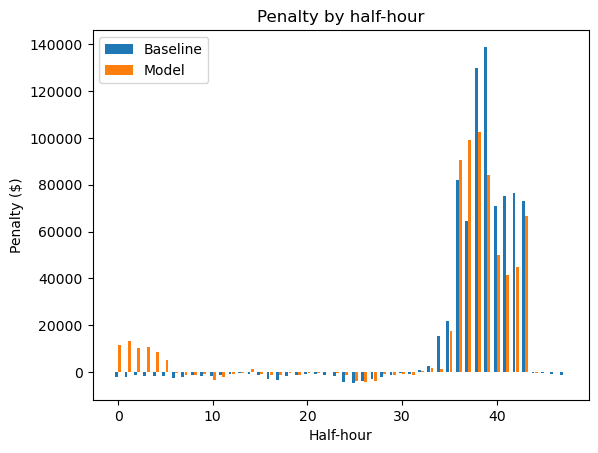

In [135]:
# plot penalty by hour
x = np.arange(len(modelPenaltyHourly))
width = 0.3

# metric_name = 'mean_absolute_error'
# metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
# val_mae = [v[metric_index] for v in multi_val_performance.values()]
# test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, baselinePenaltyHourly, width, label='Baseline')
plt.bar(x + 0.17, modelPenaltyHourly, width, label='Model')
# plt.xticks(ticks=x, labels=multi_test_performance.keys(),rotation=45)
plt.ylabel(f'Penalty ($)')
plt.xlabel(f'Half-hour')
_ = plt.legend()
plt.title(f'Penalty by half-hour')
plt.savefig('Penalty by half-hour.png', format='png')

In [136]:
modelBenefit = baselinePenalty - modelPenalty
modelBenefitPerCustomer = modelBenefit / 4987
print('\nBaseline penalty: ${:,.2f}'.format(baselinePenalty))
print('Model penalty: ${:,.2f}'.format(modelPenalty))
print('Net Model benefit: ${:,.2f}'.format(modelBenefit))
print('Net Model benefit per customer: ${:,.2f}'.format(modelBenefitPerCustomer))


Baseline penalty: $691,820.28
Model penalty: $627,629.29
Net Model benefit: $64,191.00
Net Model benefit per customer: $12.87
